<a href="https://colab.research.google.com/github/Jojo31100/Projet_8-Future_Vision_Transport-PUBLIC/blob/main/FutureVisionTransport_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projet n°8 - Future Vision Transport : Traitez les images pour le système embarqué d'une voiture autonome**

[Lien vers le projet et les attendus](https://openclassrooms.com/fr/paths/795/projects/1517/)

**Prêt à mener la mission ?**

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Vous êtes l'un des ingénieurs IA au sein de l'équipe R&D de cette entreprise. Votre équipe est composée d'ingénieurs aux profils variés. Chacun des membres de l'équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur.

Voici les différentes parties du système :

1. acquisition des images en temps réel
2. traitement des images
3. segmentation des images (c'est vous !)
4. système de décision

*Vous travaillez sur la partie de segmentation des images (3) qui est alimentée par le bloc de traitement des images (2) et qui alimente le système de décision (4).*

---

Votre rôle est de concevoir un premier modèle de segmentation d'images qui devra s'intégrer facilement dans la chaîne complète du système embarqué.

Lors d'une première phase de cadrage, vous avez récolté les avis de Franck et Laura, qui travaillent sur les parties avant et après votre intervention :

    FRANCK, en charge du traitement des images (2) :
    Le jeu de données que Franck utilise est disponible à ce lien (https://www.cityscapes-dataset.com/dataset-overview/),
    ou en téléchargement direct à ces liens :
    - 1 (https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip)
    ou
    - 2 (https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip),
    (images segmentées et annotées de caméras embarquées). On a uniquement besoin des 8 catégories principales
    (et non pas des 32 sous-catégories)


    LAURA, en charge du système de décision (4)
    Souhaite une API simple à utiliser.
    L'API prend en entrée une image et renvoie la segmentation de l'image de l'algo.

---

Pour récapituler, vous avez dressé un plan d'action, avec les points suivants :

- entraîner un modèle de segmentation des images sur les 8 catégories principales. Keras est le framework de travail commun à toute l'équipe. Attention aux contraintes de Franck !
- concevoir une API de prédiction (Flask ou FastAPI) qui sera utilisée par Laura et la déployer sur le Cloud (Azure, Heroku, PythonAnywhere ou toute autre solution). Cette API prend en entrée une image et renvoie le mask prédit (segments prédits de l'image).
- concevoir une application web (Flask, Streamlit) de présentation des résultats et la déployer sur le Cloud (Azure, Heroku, PythonAnywhere ou toute autre solution). Cette application sera l'interface pour tester l'API et afficher les images et masks.

# Initialisation : chargement des bibliothèques Python et des fonctions globales

# Partie 1 : installation des pipelines

On part du principe qu'on va utiliser Google Colab pour le développement, tout en liant le compte avec GitHub, dans lequel on a créé un repository public nommé ["Projet_8-Future_Vision_Transport-PUBLIC"](https://github.com/Jojo31100/Projet_8-Future_Vision_Transport-PUBLIC)


## 1.1 MLflow + ngrok

In [ ]:
!pip install mlflow
!pip install pyngrok

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
from pyngrok import ngrok
import time
import os
from google.colab import drive
import urllib.parse #Pour gérer l'encodage des chemins


#Nettoyage avant de commencer
!kill $(lsof -t -i:5000 || lsof -t -i:5001) 2>/dev/null
ngrok.kill()
!kill $(lsof -t -i:5000 || lsof -t -i:5001) 2>/dev/null
ngrok.kill()
!kill $(lsof -t -i:5000 || lsof -t -i:5001) 2>/dev/null
ngrok.kill()

#Etape 1 : connexion à Google Drive
drive.mount("/content/drive/")

#Etape 2 : définition et création du dossier MLflow sur Google Drive
baseMLflowPath = "Colab_Notebooks/Project_8/MLflow_data"
fullGoogleColabPath = os.path.join("/content/drive/My Drive", baseMLflowPath)

#Etape 3 : création du dossier s'il n'existe pas
os.makedirs(fullGoogleColabPath, exist_ok=True)
print(f"Dossier MLflow à l'emplacement : {fullGoogleColabPath}")

#Etape 4 : configuration de l'URI
mlflow.set_tracking_uri(f"file://{fullGoogleColabPath}")
print("MLflow Python tracking URI défini sur :", mlflow.get_tracking_uri())

#Etape 5 : nettoyage ngrok et configuration du token
ngrokAuthToken = "30GdRuK989WiPWr5DbDm7Zv23eF_7j5moxUiutbaNa85GnjUP"
ngrok.set_auth_token(ngrokAuthToken)

#Etape 6 : lancement de l'interface utilisateur de MLflow avec ngrok
backendUriForUiCommand = f'"{fullGoogleColabPath}"'
print("Lancement de MLflow UI avec --backend-store-uri :", backendUriForUiCommand)

#Etape 7 : lancement de l'UI MLflow en arrière-plan
get_ipython().system_raw(f"mlflow ui --backend-store-uri {backendUriForUiCommand} --port 5000 &")

#Etape 8 : attendre que l'UI MLflow démarre
print("\nDémarrage de l'interface utilisateur de MLflow et chargement des fichiers de données...\nMerci de patienter une petite 30aine de secondes...")
time.sleep(30)

#Etape 9 : création du tunnel ngrok
try:
    ngrokTunnel = ngrok.connect(addr="5000", proto="http")
    print("\n\nPour accéder à l'UI de MLflow, cliquez ici :", ngrokTunnel.public_url, "\n---> Sur le prochain écran, cliquez sur le bouton [Visit Site] ! ;)\n")
except Exception as error:
    print("Erreur lors de la création du tunnel ngrok :", error)
    print("Veuillez vérifier que ngrok est correctement installé, authentifié, et que MLflow UI est bien en cours d'exécution...")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Dossier MLflow à l'emplacement : /content/drive/My Drive/Colab_Notebooks/Project_8/MLflow_data
MLflow Python tracking URI défini sur : file:///content/drive/My Drive/Colab_Notebooks/Project_8/MLflow_data
Lancement de MLflow UI avec --backend-store-uri : "/content/drive/My Drive/Colab_Notebooks/Project_8/MLflow_data"

Démarrage de l'interface utilisateur de MLflow et chargement des fichiers de données...
Merci de patienter une petite 30aine de secondes...


Pour accéder à l'UI de MLflow, cliquez ici : https://34f4a892bd69.ngrok-free.app 
---> Sur le prochain écran, cliquez sur le bouton [Visit Site] ! ;)



###1.1.1 Screenshots MLflow

Le chargement des données de MLflow depuis Google Drive étant *parfois* capricieux, et particulièrement **long** et **lent**, il m’a semblé pertinent de réaliser des captures d’écran à destination de l’examinateur, plutôt que de risquer un plantage en boucle lors du chargement des fichiers depuis Google Drive le jour de la soutenance/démonstration.

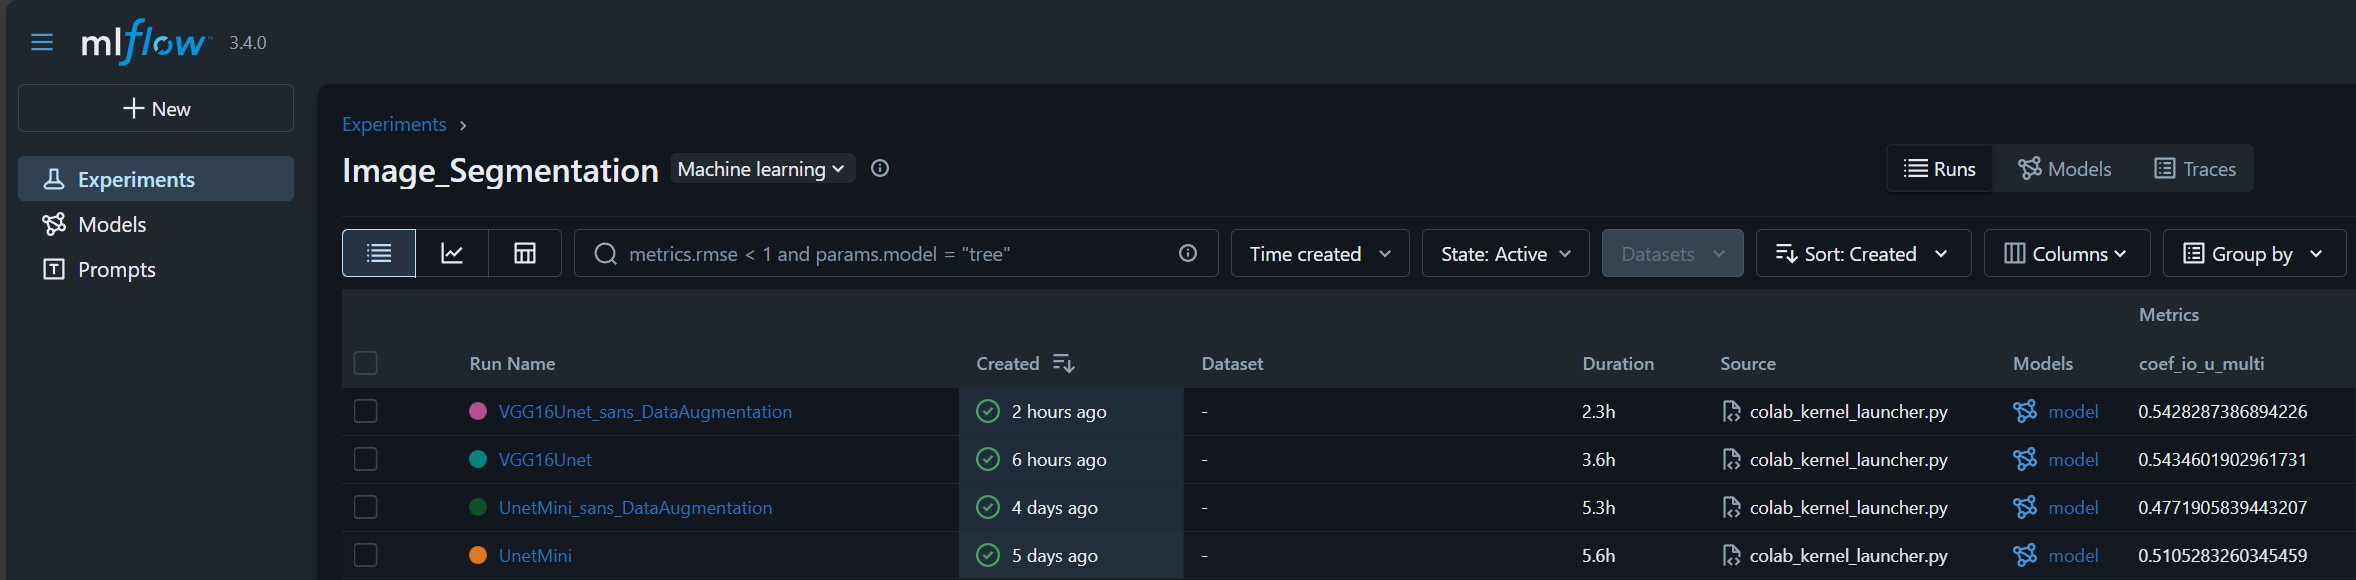

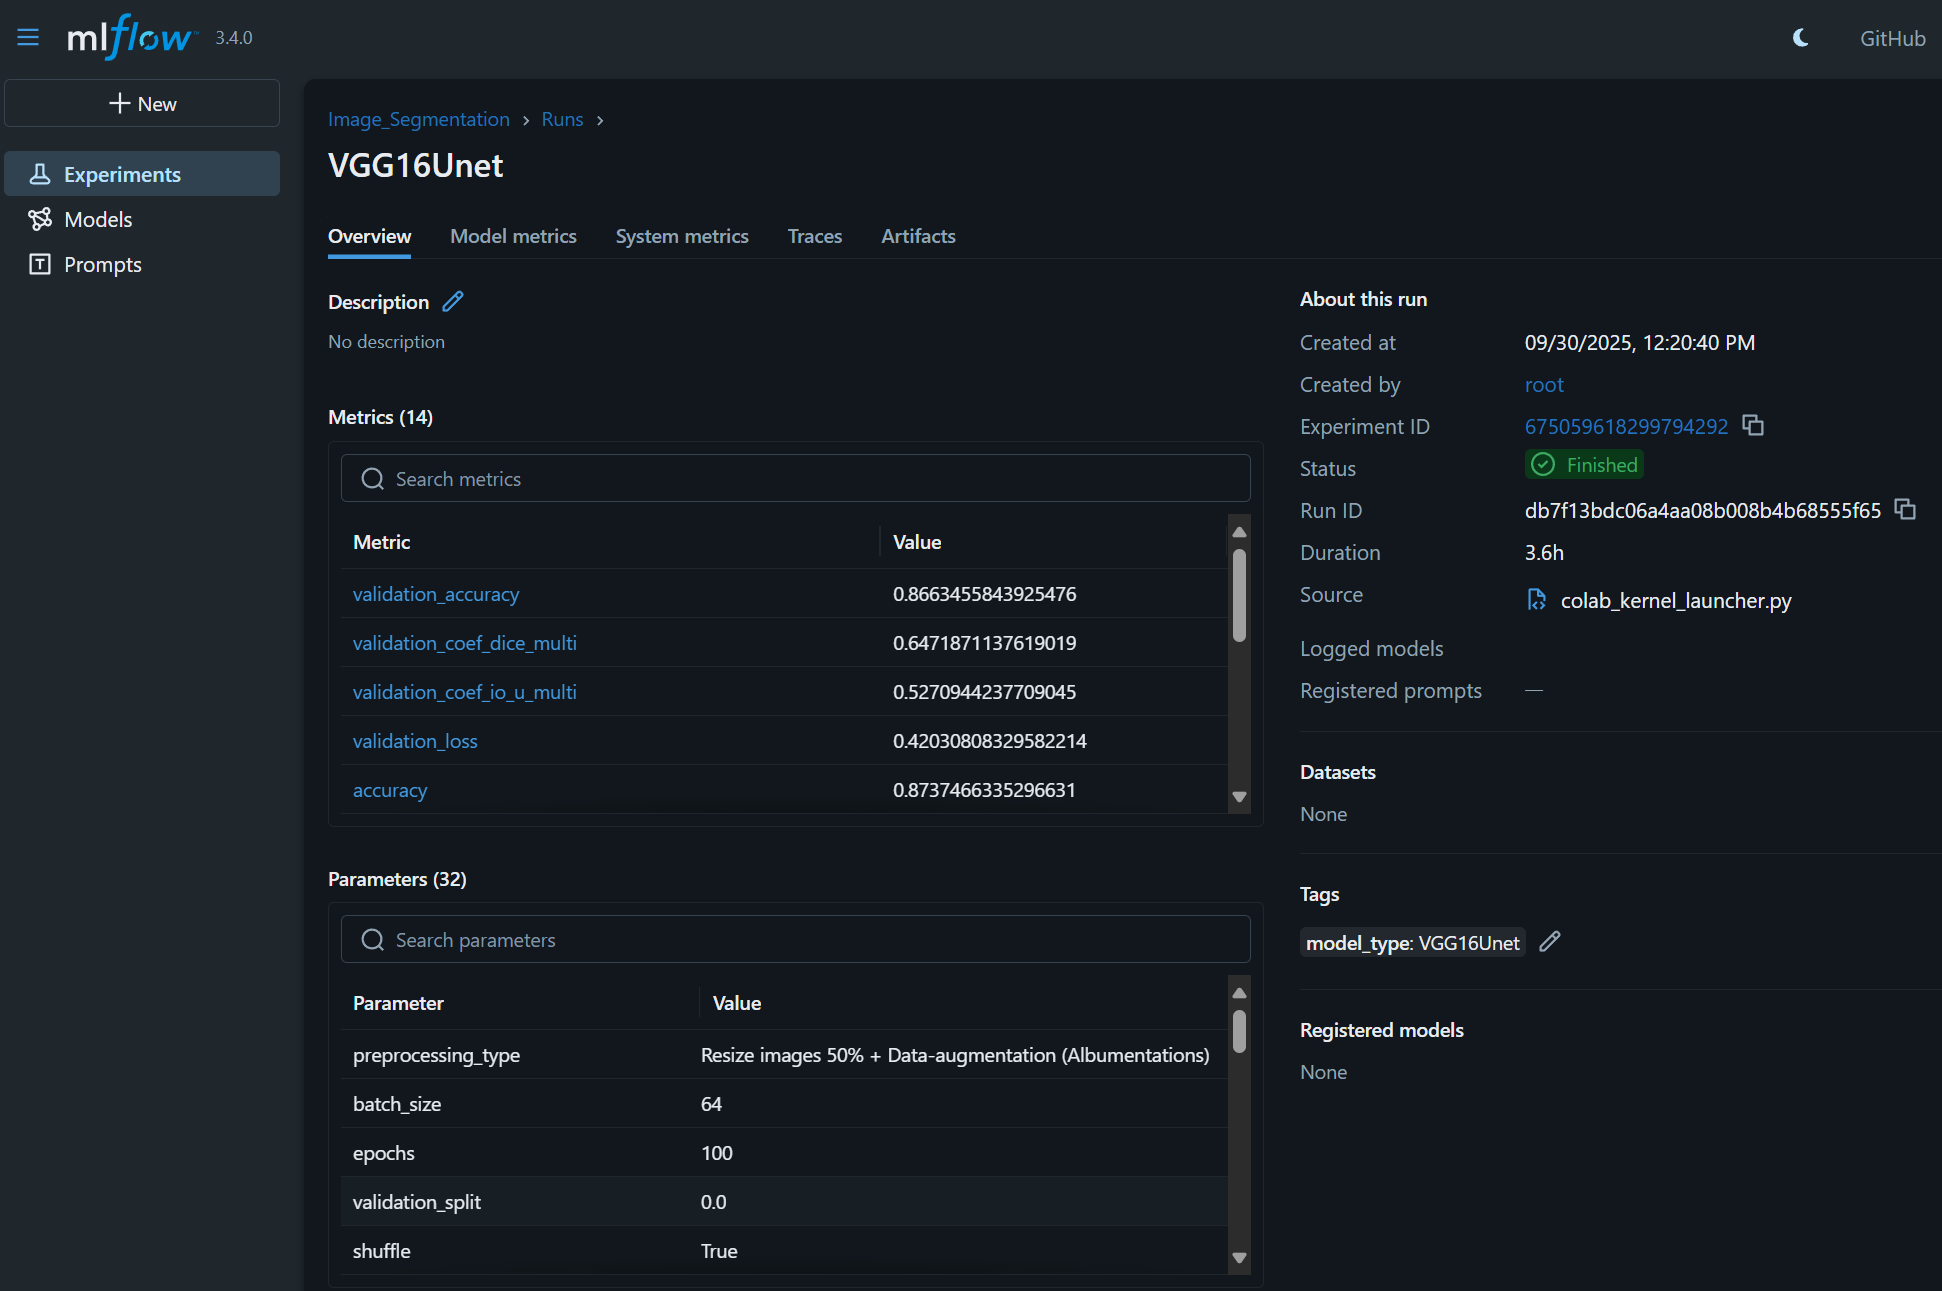

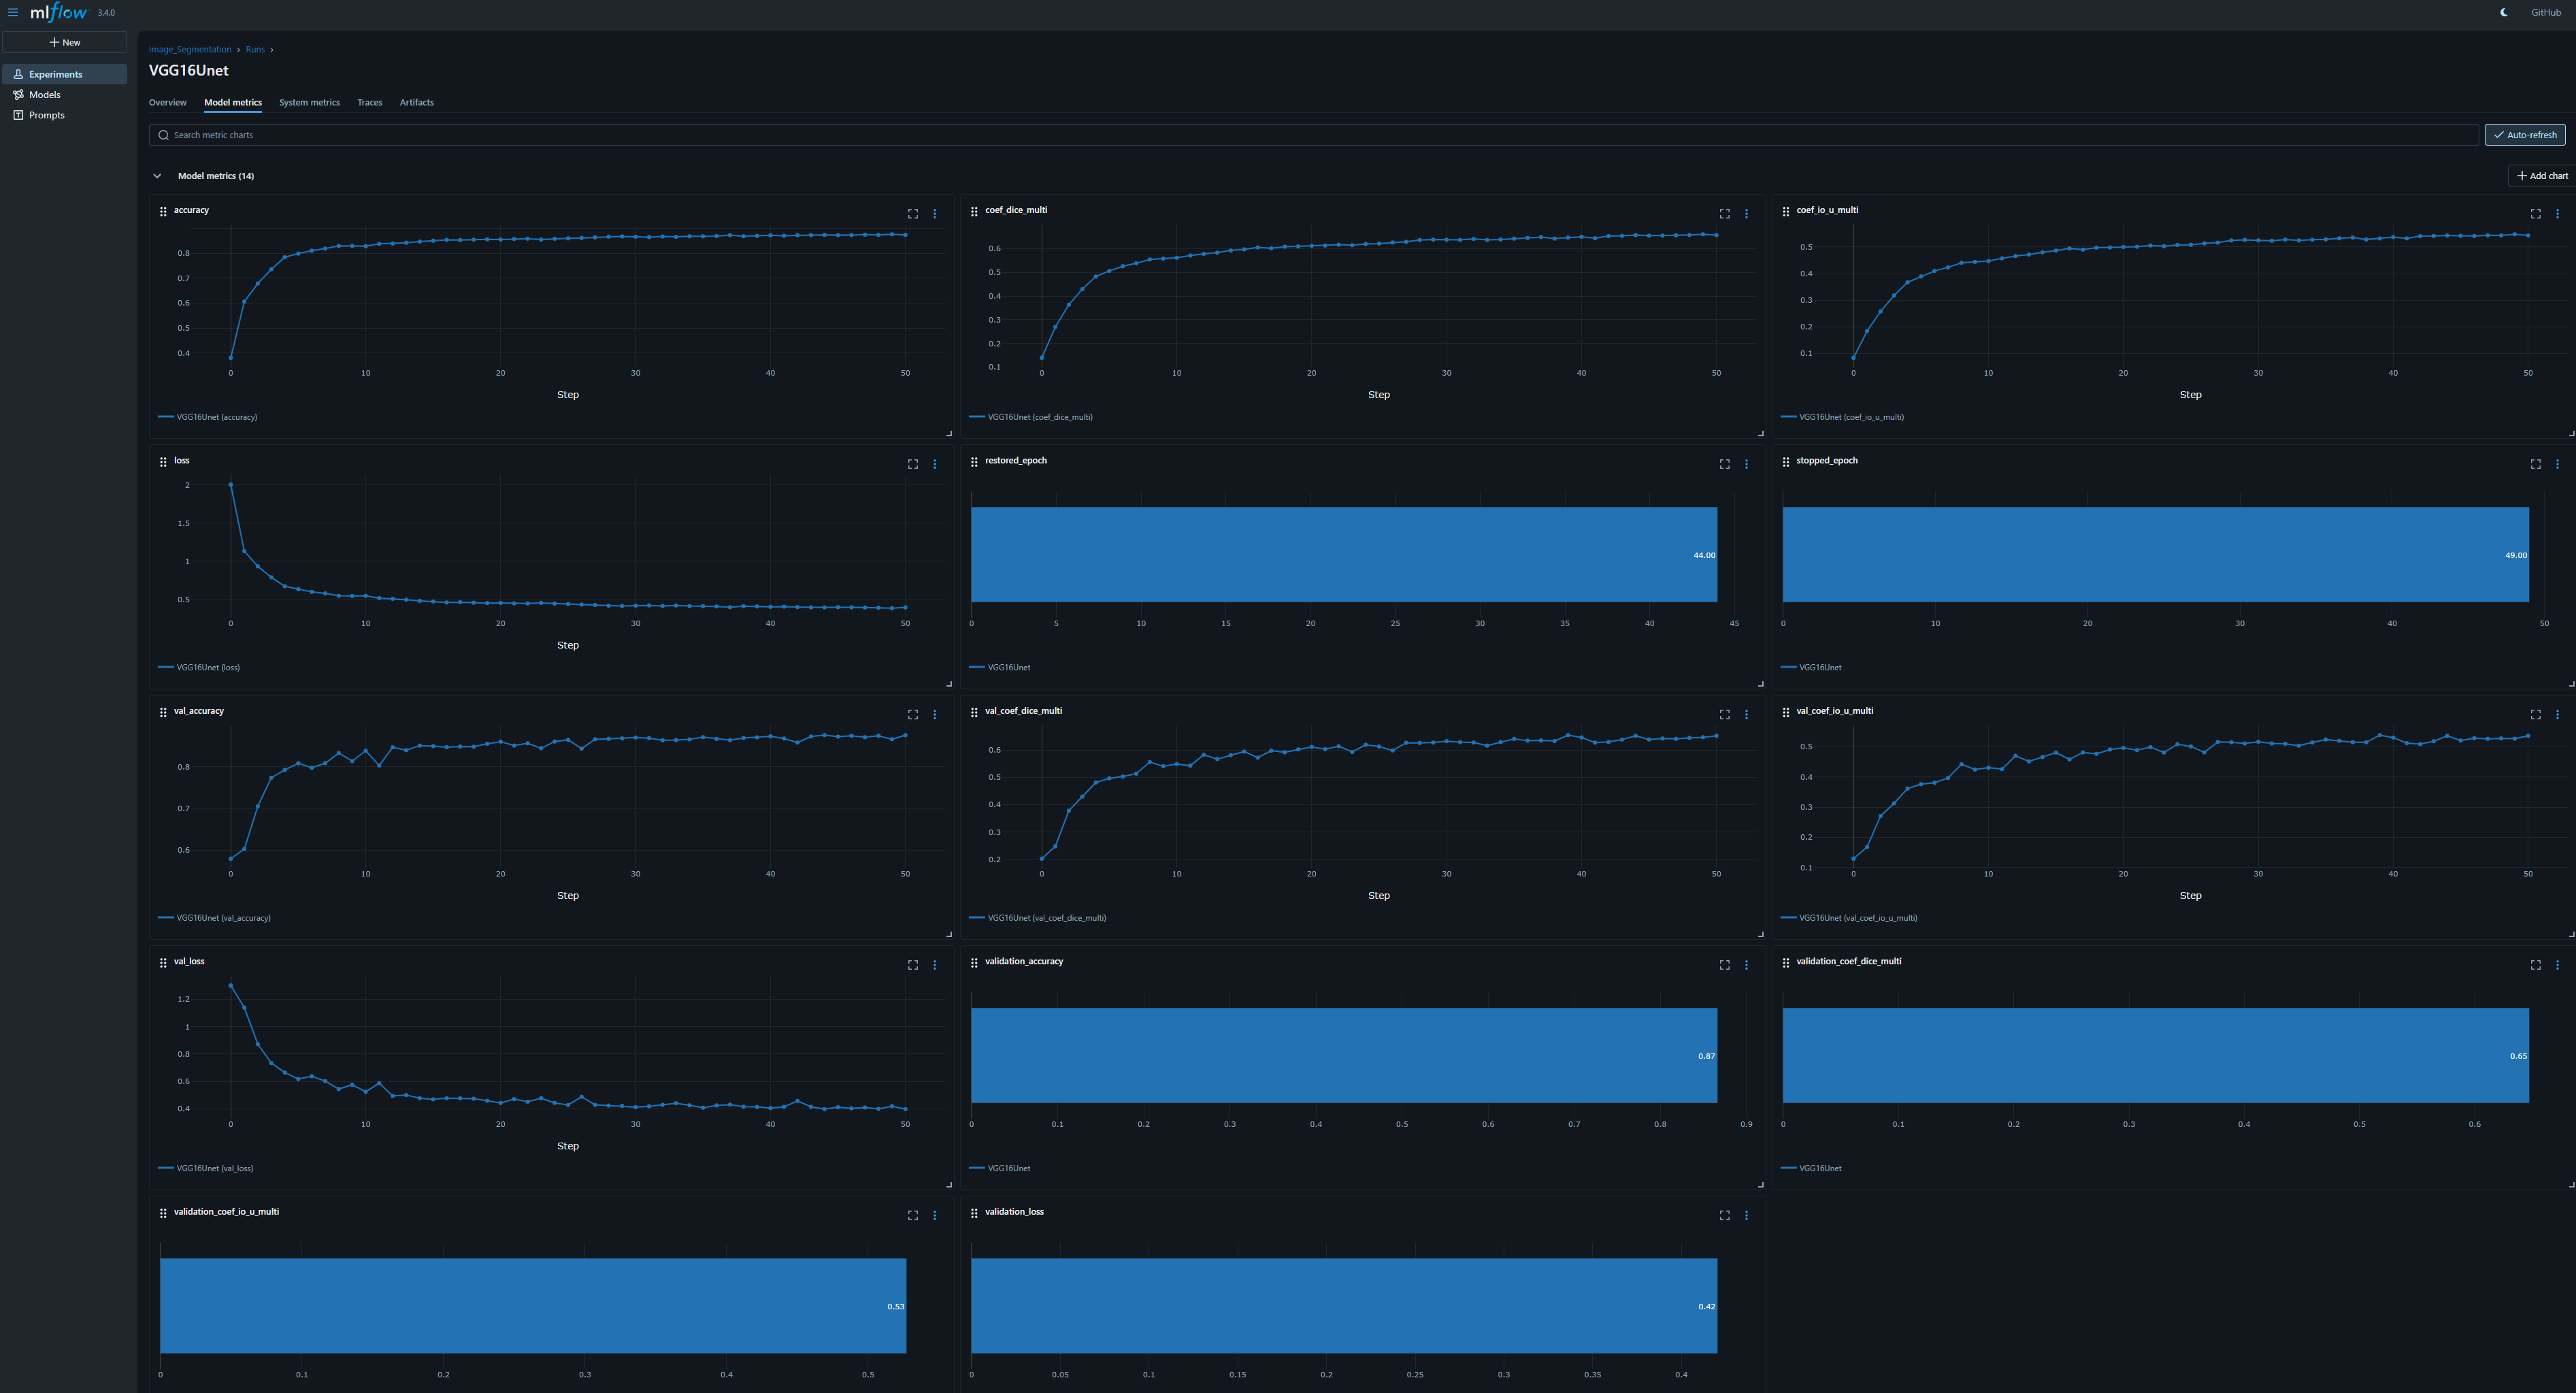

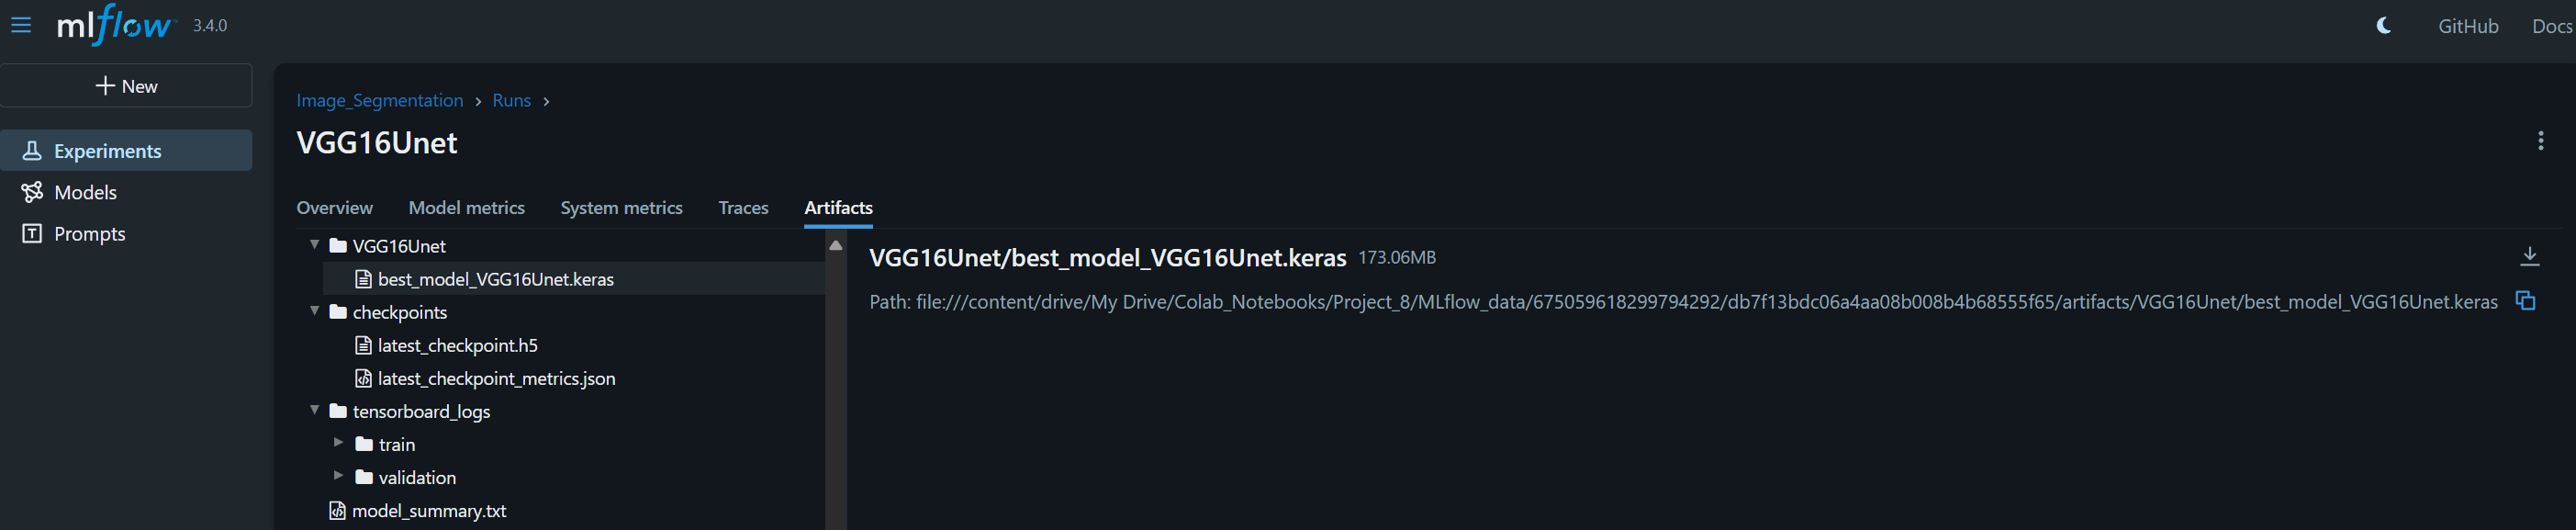

# Partie 2 : analyse exploratoire des données

In [ ]:
#Imports Partie 2
import os
from google.colab import drive
import json
import pandas
from PIL import Image
import matplotlib

<u>**Les données sont constituées de 2 fichiers .ZIP :**</u>

- <font color="#AA00AA">**P8_Cityscapes_gtFine_trainvaltest.zip**</font> (*240mo* compressés / *771mo* décompressés), contient :
  - Les **ColorMaps** (ou **Masques colorés**)
    - Fichiers au format : <font color="#00FF00">*VILLE*</font>**_**<font color="#00FFFF">*NUMERO-ID*</font>**_gtFine_color.png**
    - Sert à la visualisation "humaine"
  - Les **Labels** (ou **Masques sémantiques**)
    - Fichiers au format : <font color="#00FF00">*VILLE*</font>**_**<font color="#00FFFF">*NUMERO-ID*</font>**_labelIds.png**
    - Chaque pixel prend une valeur d'ID correspondant à une catégorie/classe (0 = void, 1 = flat, 2 = human, etc)
  - Les **Instances** (ou **Masques d'instances**)
    - Fichiers au format : <font color="#00FF00">*VILLE*</font>**_**<font color="#00FFFF">*NUMERO-ID*</font>**_instanceIds.png**
    - Chaque instance d'une même catégorie/classe détectée reçoit un ID unique (pour distinguer UNITAIREMENT chaque voiture détectée, par exemple)
  - Les **Délimitations Polygonales** (pour les *ColorMaps/Masks*)
    - Fichiers au format : <font color="#00FF00">*VILLE*</font>**_**<font color="#00FFFF">*NUMERO-ID*</font>**_polygons.json**

---

- <font color="#AA00AA">**P8_Cityscapes_leftImg8bit_trainvaltest.zip**</font> (*10,7go* compressés / *10,7go* décompressés), contient :
  - Contient les photos de circulation des caméras embarquées (dont sont issus : *ColorMaps*, *Labels*/*Masks* et *JSON* précédents)
    - Fichiers au format : <font color="#00FF00">*VILLE*</font>**_**<font color="#00FFFF">*NUMERO-ID*</font>**_leftImg8bit.png**

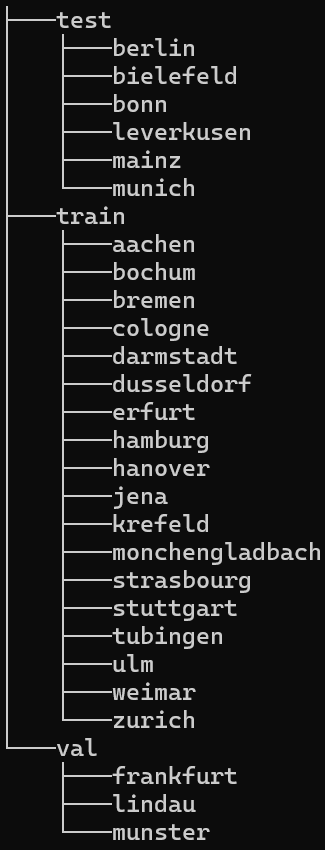

La 1ère chose à faire est de vérifier l'intégrité des données !

- Pour chaque répertoire "**Train**"/"**Val**"/"**Test*"
  - Pour pour chaque "**Ville**"
    - Pour chaque "**Image**", vérification définition : 2048x1024 pixels en 24 bits
      - Présence du fichier "**ColorMap**" ? + vérification définition : 2048x1024 pixels en 32 bits
      - Présence du fichier "**Labels**" ? + vérification définition :2048x1024 pixels en 8 bits
      - Présence du fichier "**Instances**" ? + vérification définition : 2048x1024 pixels en 16 bits
      - Présence du fichier "**JSON**" ? + vérification taille > 0 octet

In [ ]:
#VERIFICATION DE L'INTEGRITE DES DONNEES
#On vérifie, notamment :
# - qu'il n'y ait pas de fichiers orphelins
# - la définition des images
# - le nombre de pixels de chaque classe dans les masques
#... et on stocke toutes ces infos dans un dataframe Pandas !


#Connexion à Google Drive
drive.mount("/content/drive/")

#Etape 1 : définition du dossier racine dans Google Drive
projectPath = "Colab_Notebooks/Project_8/dataset/"
rootDir = os.path.join("/content/drive/My Drive", projectPath)

#Etape 2 : vérification de l'intégrité des données
resultats = []
#Pour chaque répertoire dans la Racine
for nomRepertoire in ["train", "val", "test"]:
    sousRepertoire = os.path.join(rootDir, nomRepertoire)
    if(not os.path.exists(sousRepertoire)):
        continue

    #Affichage de l'avancement
    print("Traitement de :", nomRepertoire)

    #Pour chaque VILLE
    for nomVille in os.listdir(sousRepertoire):
        sousRepertoireVille = os.path.join(sousRepertoire, nomVille)
        if(not os.path.isdir(sousRepertoireVille)):
            continue

        #Affichage de l'avancement
        print("\t--> Ville :", nomVille)

        #Pour chaque IMAGE de caméra embarquée
        for nomImage in os.listdir(sousRepertoireVille):
            if(nomImage.endswith("_leftImg8bit.png")):
                baseNom = nomImage.replace("_leftImg8bit.png", "")
                nomImageComplet = os.path.join(sousRepertoireVille, nomImage)

                #Vérification de la définition de l'image
                try:
                    with Image.open(nomImageComplet) as image:
                        x, y = image.size
                        mode = image.mode #normalement "RGB"
                        if(mode == "RGB"):
                            profondeurCouleursOK = True
                        else:
                            profondeurCouleursOK = False
                        if(x==2048 and y==1024 and profondeurCouleursOK==True):
                            status = "OK"
                        else:
                            status = f"NON OK ({x}x{y}, {mode})"
                except Exception as excpt:
                    status = f"ERROR ({excpt})"

                #Vérification de la ColorMap
                nomColorMap = os.path.join(sousRepertoireVille, baseNom + "_gtFine_color.png")
                if(os.path.exists(nomColorMap)):
                    with Image.open(nomColorMap) as colorMap:
                        x, y = colorMap.size
                        mode = colorMap.mode #normalement "RGB"
                        if(mode == "RGB" or mode == "RGBA"):
                            profondeurCouleursOK = True
                        else:
                            profondeurCouleursOK = False
                        if(x==2048 and y==1024 and profondeurCouleursOK==True):
                            colorMapStatus = "OK"
                        else:
                            colorMapStatus = f"NON OK ({x}x{y}, {mode})"
                else:
                    colorMapStatus = "MANQUANT"

                #Vérification des Labels
                nomLabel = os.path.join(sousRepertoireVille, baseNom + "_gtFine_labelIds.png")
                if(os.path.exists(nomLabel)):
                    with Image.open(nomLabel) as label:
                        x, y = label.size
                        mode = label.mode #normalement "L"
                        if(mode == "L"):
                            profondeurCouleursOK = True
                        else:
                            profondeurCouleursOK = False
                        if(x==2048 and y==1024 and profondeurCouleursOK==True):
                            labelStatus = "OK"
                        else:
                            labelStatus = f"NON OK ({x}x{y}, {mode})"

                        #Mapping IDs (au nombre 34) par Classe (au nombre de 8)
                        # --> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
                        mappingIdsToGroup = {
                            0: "void", 1: "void", 2: "void", 3: "void", 4: "void", 5: "void", 6: "void", 34: "void",
                            7: "flat", 8: "flat", 9: "flat", 10: "flat",
                            11: "construction", 12: "construction", 13: "construction", 14: "construction", 15: "construction", 16: "construction",
                            17: "object", 18: "object", 19: "object", 20: "object",
                            21: "nature", 22: "nature",
                            23: "sky",
                            24: "human", 25: "human",
                            26: "vehicle", 27: "vehicle", 28: "vehicle", 29: "vehicle", 30: "vehicle", 31: "vehicle", 32: "vehicle", 33: "vehicle"
                        }

                        #Initialisation des compteurs de pixels par Classe
                        compteurPixels = {
                            "flat": 0,
                            "human": 0,
                            "vehicle": 0,
                            "construction": 0,
                            "object": 0,
                            "nature": 0,
                            "sky": 0,
                            "void": 0
                        }

                        #Conversion du fichier Label en liste de pixels
                        listePixels = list(label.getdata())

                        # Comptage des pixels
                        for pixel in listePixels:
                            group = mappingIdsToGroup.get(pixel, "void")  #Si jamais on tombe sur un ID inconnu --> Classe "void"
                            compteurPixels[group] += 1
                else:
                    labelStatus = "MANQUANT"

                    #Si le fichier label est manquant, tous les compteurs restent à 0
                    compteurPixels = {
                        "flat": 0,
                        "human": 0,
                        "vehicle": 0,
                        "construction": 0,
                        "object": 0,
                        "nature": 0,
                        "sky": 0,
                        "void": 0
                    }
                    for group in ["flat", "human", "vehicle", "construction", "object", "nature", "sky", "void"]:
                        compteurPixels[group] = 0

                #Vérification des Instances
                nomInstance = os.path.join(sousRepertoireVille, baseNom + "_gtFine_instanceIds.png")
                if(os.path.exists(nomInstance)):
                    with Image.open(nomInstance) as instance:
                        x, y = instance.size
                        mode = instance.mode #normalement "I" ou "I;16"
                        if mode in ["I", "I;16"]:
                            profondeurCouleursOK = True
                        else:
                            profondeurCouleursOK = False
                        if(x==2048 and y==1024 and profondeurCouleursOK==True):
                            instanceStatus = "OK"
                        else:
                            instanceStatus = f"NON OK ({x}x{y}, {mode})"
                else:
                    instanceStatus = "MANQUANT"

                #Vérification JSON
                nomJSON = os.path.join(sousRepertoireVille, baseNom + "_gtFine_polygons.json")
                if(os.path.exists(nomJSON)):
                    tailleJSON = os.path.getsize(nomJSON)
                    if(tailleJSON > 0):
                        jsonStatus = "OK"
                    elif(tailleJSON==0):
                        jsonStatus = "VIDE"
                else:
                    jsonStatus = "MANQUANT"

                resultats.append({
                    "Répertoires": nomRepertoire,
                    "Villes": nomVille,
                    "Fichiers": nomImage,
                    "Images": status,
                    "ColorMaps": colorMapStatus,
                    "Labels": labelStatus,
                    "Instances": instanceStatus,
                    "JSONs": jsonStatus,
                    "Nb pixels groupe FLAT": compteurPixels["flat"],
                    "Nb pixels groupe HUMAN": compteurPixels["human"],
                    "Nb pixels groupe VEHICLE": compteurPixels["vehicle"],
                    "Nb pixels groupe CONSTRUCTION": compteurPixels["construction"],
                    "Nb pixels groupe OBJECT": compteurPixels["object"],
                    "Nb pixels groupe NATURE": compteurPixels["nature"],
                    "Nb pixels groupe SKY": compteurPixels["sky"],
                    "Nb pixels groupe VOID": compteurPixels["void"]
                })

#Etape 3 : on stocke le tout dans un dataframe Pandas !
dataframe = pandas.DataFrame(resultats)
dataframe.head(50)

#Etape 4 : on stocke également les résultats sous forme de fichier CSV, pour une inspection complète !
dataframe.to_csv("/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/IntergityCheck.csv", index=False, sep=";")

Mounted at /content/drive/
Traitement de : train
	--> Ville : aachen
	--> Ville : bochum
	--> Ville : bremen
	--> Ville : cologne
	--> Ville : darmstadt
	--> Ville : dusseldorf
	--> Ville : erfurt
	--> Ville : hanover
	--> Ville : hamburg
	--> Ville : jena
	--> Ville : krefeld
	--> Ville : monchengladbach
	--> Ville : strasbourg
	--> Ville : stuttgart
	--> Ville : tubingen
	--> Ville : ulm
	--> Ville : weimar
	--> Ville : zurich
Traitement de : val
	--> Ville : frankfurt
	--> Ville : lindau
	--> Ville : munster
Traitement de : test
	--> Ville : bielefeld
	--> Ville : berlin
	--> Ville : mainz
	--> Ville : munich
	--> Ville : leverkusen
	--> Ville : bonn


In [ ]:
dataframe

Répertoires  Villes                              Fichiers Images  \
0          train  aachen  aachen_000020_000019_leftImg8bit.png     OK   
1          train  aachen  aachen_000043_000019_leftImg8bit.png     OK   
2          train  aachen  aachen_000091_000019_leftImg8bit.png     OK   
3          train  aachen  aachen_000070_000019_leftImg8bit.png     OK   
4          train  aachen  aachen_000142_000019_leftImg8bit.png     OK   
...          ...     ...                                   ...    ...   
4995        test    bonn    bonn_000001_000019_leftImg8bit.png     OK   
4996        test    bonn    bonn_000006_000019_leftImg8bit.png     OK   
4997        test    bonn    bonn_000010_000019_leftImg8bit.png     OK   
4998        test    bonn    bonn_000023_000019_leftImg8bit.png     OK   
4999        test    bonn    bonn_000027_000019_leftImg8bit.png     OK   

     ColorMaps Labels Instances JSONs  Nb pixels groupe FLAT  \
0           OK     OK        OK    OK                 224061   
1           OK     OK        OK    OK                 783680   
2           OK     OK        OK    OK                 535217   
3           OK     OK        OK    OK                 982396   
4           OK     OK        OK    OK                 649890   
...        ...    ...       ...   ...                    ...   
4995        OK     OK        OK    OK                      0   
4996        OK     OK        OK    OK                      0   
4997        OK     OK        OK    OK                      0   
4998        OK     OK        OK    OK                      0   
4999        OK     OK        OK    OK                      0   

      Nb pixels groupe HUMAN  Nb pixels groupe VEHICLE  \
0                     159254                     11463   
1                          0                    450177   
2                      65365                    616203   
3                      16346                    114447   
4                        546                    123233   
...                      ...                       ...   
4995                       0                         0   
4996                       0                         0   
4997                       0                         0   
4998                       0                         0   
4999                       0                         0   

      Nb pixels groupe CONSTRUCTION  Nb pixels groupe OBJECT  \
0                            772876                    25228   
1                            502174                     9786   
2                            506097                     3643   
3                            501188                    21044   
4                            657709                     5748   
...                             ...                      ...   
4995                              0                        0   
4996                              0                        0   
4997                              0                        0   
4998                              0                        0   
4999                              0                        0   

      Nb pixels groupe NATURE  Nb pixels groupe SKY  Nb pixels groupe VOID  
0                       50818                     0                 853452  
1                      218958                 11622                 120755  
2                      225688                 29275                 115664  
3                      169741                159066                 132924  
4                      500565                 24714                 134747  
...                       ...                   ...                    ...  
4995                        0                     0                2097152  
4996                        0                     0                2097152  
4997                        0                     0                2097152  
4998                        0                     0                2097152  
4999                        0                 

In [ ]:
#Connexion à Google Drive
drive.mount("/content/drive/")
dataframe = pandas.read_csv("/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/IntergityCheck.csv", sep=";")

Mounted at /content/drive/


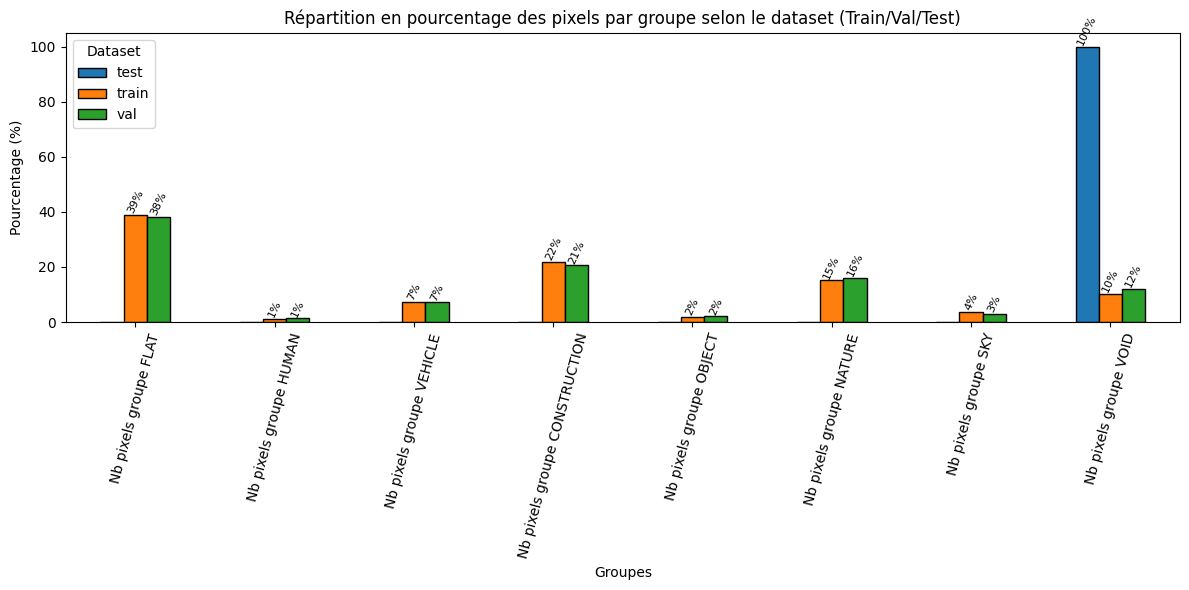

In [ ]:
#Affichage de l'équilibre des groupes sous forme d'histogramme


#Colonnes des pixels
colonnesDesGroupes = [
    "Nb pixels groupe FLAT",
    "Nb pixels groupe HUMAN",
    "Nb pixels groupe VEHICLE",
    "Nb pixels groupe CONSTRUCTION",
    "Nb pixels groupe OBJECT",
    "Nb pixels groupe NATURE",
    "Nb pixels groupe SKY",
    "Nb pixels groupe VOID"
]

#Regroupement par "dataset"/"répertoire" (Train, Val, Test) et somme des pixels
pixelsParDataset = dataframe.groupby("Répertoires")[colonnesDesGroupes].sum()

#Conversion en pourcentages par "Répertoire"
pixelsPourcents = pixelsParDataset.div(pixelsParDataset.sum(axis=1), axis=0) * 100

#Histogramme
histo = pixelsPourcents.T.plot(kind="bar", figsize=(12, 6), edgecolor="black")
matplotlib.pyplot.title("Répartition en pourcentage des pixels par groupe selon le dataset (Train/Val/Test)")
matplotlib.pyplot.ylabel("Pourcentage (%)")
matplotlib.pyplot.xlabel("Groupes")
matplotlib.pyplot.xticks(rotation=75)
matplotlib.pyplot.legend(title="Dataset")
matplotlib.pyplot.tight_layout()
#Ajout des pourcentages au-dessus de chaque barre
for prct in histo.patches:
    height = prct.get_height()
    if(height > 0): #On va éviter d'écrire 0% sur les barres vides... Déjà parce que c'est "moyen utile", mais aussi parce que c'est juste moche, soyons francs ! :p
        histo.annotate(f"{height:.0f}%", (prct.get_x() + prct.get_width() / 2, height), ha="center", va="bottom", fontsize=8, rotation=65)
matplotlib.pyplot.show()

<u>**Grâce à cet histogramme, 3 choses nous sautent IMMEDIATEMENT aux yeux :**</u>

1. La répartition des groupes entre "Train" et "Val" est très équilibrée (*à 1 ou 2% près !*), ce qui va particulièrement bien arranger nos affaire pour la suite (= recréation d'un dataset) ! :p

---

2. Les données de "**Test**" sont **100% VOID**, ce qui veut dire, tout simplement, que les masques sémantiques (les fichiers *_labelIds*) sont **100% vides** !
- <u>Conclusion</u> : ils seront **totalement inutilisables** pour tester notre/nos modèle(s)...

---

3. Autant d'un point de vue purement "*mathématique*", le déséquilibre entre les groupes "**HUMANS**", "**OBJECT**" et "**SKY**", par rapport aux autres données est assez important et rique d'amener un biais durant l'entraînement du modèle.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;... Autant, d'un point de vue sécuritaire, ce déséquilibre, sur le groupe "HUMANS", pourrait avoir

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;des répercussions sécuritaires **<font color="#FF0000">graves</font>**, voire **<font color="#FF0000">létales</font>** !

➡️**Il faudra donc bien veiller à jouer sur la "<font color="#00FF00">loss</font>" pour remonter le poids du groupe "HUMANS" !** ⚠️

# Partie 3 : génération d'un dataset viable

In [ ]:
#Imports Partie 3
import os
from google.colab import drive
import pandas
import math
import shutil
import matplotlib

Comme on l'a vu, le dataset actuel n'est pas utilisable en l'état : les données de Tests ne permettront tout simplement pas de tester notre modèle !

L'idée va être de :
1. "supprimer" les données de Test
2. "fusionner" les données de Train et Val
3. "*TrainTestSplit*" les données fusionnées en Train/Val

In [ ]:
#CREATION DU NOUVEAU DATAFRAME (FUSION "TRAIN"+"VAL" ET DROP "TEST")
#VERIFICATION DE L'INTEGRITE DES DONNEES
#On vérifie, notamment :
# - la nouvelle répartition des fichiers
# - la définition des images
# - le nombre de pixels de chaque classe dans les masques
#... et on stocke toutes ces infos dans un dataframe Pandas !


#On part du dataframe existant
dataframeTemp = dataframe.copy()

#On drop les individus dont la variable "Répertoires"=="test" (inutiles, car remplis de VOID, comme on l'a vu précédemment)
dataframeTemp = dataframeTemp[dataframeTemp["Répertoires"] != "test"].reset_index(drop=True)

#On rajoute une variable "Nouveaux répertoires"
dataframeTemp["Nouveaux répertoires"] = ""

#On trie par "Villes" puis par "Fichiers"
dataframeTemp = dataframeTemp.sort_values(by=["Villes", "Fichiers"]).reset_index(drop=True)

#On traite les données, ville après ville, avec une répartition de type : 60%-10%-30% pour "Train", "Val" et "Tests" (pour info : même ratio que le dataset original)
# comme on l'a vu précédemment, les groupes étant particulièrement équilibrés (entre "Train" et "Val") dans le dataset original
# cette découpe "manuelle" (ou déterministe) ne devrait par poser de problème, les classes restant équilibrées...
for ville, groupe in dataframeTemp.groupby("Villes"):
    nbIndividuDansLaVille = len(groupe)

    #Calcul des index de coupure pour "Train" et "Val" ("Test"==Les individus restants de la même ville... Ca évitera de s'enquiquiner avec des arrondis ! :) )
    tailleTrain = math.ceil(0.6 * nbIndividuDansLaVille)
    tailleVal = math.ceil(0.1 * nbIndividuDansLaVille)
    index = groupe.index.tolist()

    #Attribution des tags
    dataframeTemp.loc[index[:tailleTrain], "Nouveaux répertoires"] = "train"
    dataframeTemp.loc[index[tailleTrain:tailleTrain+tailleVal], "Nouveaux répertoires"] = "val"
    dataframeTemp.loc[index[tailleTrain+tailleVal:], "Nouveaux répertoires"] = "test"

#Vérification rapide
resume = (dataframeTemp.groupby(["Villes", "Nouveaux répertoires"]).size().unstack(fill_value=0).reset_index())
print("\nRépartition des images par Ville :\n", resume)


Répartition des images par Ville :
 Nouveaux répertoires           Villes  test  train  val
0                              aachen    51    105   18
1                              bochum    28     58   10
2                              bremen    94    190   32
3                             cologne    45     93   16
4                           darmstadt    25     51    9
5                          dusseldorf    65    133   23
6                              erfurt    32     66   11
7                           frankfurt    79    161   27
8                             hamburg    74    149   25
9                             hanover    58    118   20
10                               jena    35     72   12
11                            krefeld    29     60   10
12                             lindau    17     36    6
13                    monchengladbach    27     57   10
14                            munster    51    105   18
15                         strasbourg   109    219   37
16         

In [ ]:
print("Nombre d'images uniques restantes (sur 5000, initialement) :", dataframeTemp.shape[0])

Nombre d'images uniques restantes (sur 5000, initialement) : 3475


In [ ]:
#CREATION DU NOUVEAU DATASET (COPIE DES FICHIERS IMAGES+MASQUES+COLORMAPS)
#On se sert du nouveau dataframe pour copier les fichiers (images + colorMaps + labelIds uniquement, les autres fichiers ne nous servant à rien...),
#dans un nouveau répertoire, sans s'embêter avec la ville (au pire, on pourra la retrouver grâce au nom des fichiers), et tous dans le même sous-répertoire,
#en fonction de leur utilité future ("Train", "Val" ou "Test")


#Chemin de base
cheminDatasetOriginal = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/"
cheminNouveauDataset = os.path.join(cheminDatasetOriginal, "New_dataset")

#Etape 1 : création des répertoires
os.makedirs(cheminNouveauDataset, exist_ok=True) #New_dataset
for sub in ["train", "val", "test"]: #New_dataset/train, New_dataset/val et New_dataset/test
    os.makedirs(os.path.join(cheminNouveauDataset, sub), exist_ok=True)

#Étape 2 : copie des fichiers
for index, row in dataframeTemp.iterrows():
    ville = row["Villes"]
    ancienRepertoire = row["Répertoires"]
    nouveauRepertoire = row["Nouveaux répertoires"]

    #Récupérer la racine du fichier (sans suffixe)
    fichier = row["Fichiers"].replace("_leftImg8bit.png", "")

    #Chemins source et destination pour les 3 fichiers
    fichiersACopier = [
        f"{fichier}_leftImg8bit.png",
        f"{fichier}_gtFine_color.png",
        f"{fichier}_gtFine_labelIds.png"
    ]

    #On lance la copie des fichiers
    for fichierEnCours in fichiersACopier:
        source = os.path.join(cheminDatasetOriginal, ancienRepertoire, ville, fichierEnCours)
        destination = os.path.join(cheminNouveauDataset, nouveauRepertoire, fichierEnCours)
        shutil.copy(source, destination)

Voilà, on se retrouve avec un dataset utilisable, et plus simple à utiliser :


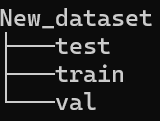

On va maintenant vérifier si les 3475 images (+3475 labelIds et +3475 colorMaps) ont bien été copiés.

Tout en vérifiant que l'équilibre des groupes ait été conservé, entre les datasets "train", "val" et "test"

In [ ]:
#VERIFICATION DE L'INTEGRITE DU NOUVEAU DATASET
#On vérifie que chaque catégorie "train" (60% du dataset), "val" (10% du dataset) et "test" (30% du dataset)
#contienne le bon nombre de fichiers (=triplet : images + colorMaps + masques),
#et on recompte le nombre de pixels de chaque classe dans les masques


#Connexion à Google Drive
drive.mount("/content/drive/")

#Etape 1 : définition du dossier racine dans Google Drive
projectPath = "Colab_Notebooks/Project_8/dataset/New_dataset"
rootDir = os.path.join("/content/drive/My Drive", projectPath)

#Etape 2 : vérification de l'intégrité des données
resultats = []
nbImagesTrain, nbImagesVal, nbImagesTest = 0, 0, 0
nbColorMapsTrain, nbColorMapsVal, nbColorMapsTest = 0, 0, 0
nbLabelIdsTrain, nbLabelIdsVal, nbLabelIdsTest = 0, 0, 0

#Pour chaque répertoire dans la Racine
for nomRepertoire in ["train", "val", "test"]:
    sousRepertoire = os.path.join(rootDir, nomRepertoire)
    if(not os.path.exists(sousRepertoire)):
        continue

    #Affichage de l'avancement
    print("Traitement de :", nomRepertoire)

    #Pour chaque IMAGE de caméra embarquée
    for nomImage in os.listdir(sousRepertoire):
        if(nomImage.endswith("_leftImg8bit.png")):
            baseNom = nomImage.replace("_leftImg8bit.png", "")
            nomImageComplet = os.path.join(sousRepertoire, nomImage)
            if(os.path.exists(nomImageComplet)):
                if(nomRepertoire == "train"):
                  nbImagesTrain = nbImagesTrain +1
                elif(nomRepertoire == "val"):
                  nbImagesVal = nbImagesVal +1
                else:
                  nbImagesTest = nbImagesTest +1

            #Vérification de la ColorMap
            nomColorMap = os.path.join(sousRepertoire, baseNom + "_gtFine_color.png")
            if(os.path.exists(nomColorMap)):
                if(nomRepertoire == "train"):
                  nbColorMapsTrain = nbColorMapsTrain +1
                elif(nomRepertoire == "val"):
                  nbColorMapsVal = nbColorMapsVal +1
                else:
                  nbColorMapsTest = nbColorMapsTest +1

            #Vérification des Labels
            nomLabel = os.path.join(sousRepertoire, baseNom + "_gtFine_labelIds.png")
            if(os.path.exists(nomLabel)):
                if(nomRepertoire == "train"):
                  nbLabelIdsTrain = nbLabelIdsTrain +1
                elif(nomRepertoire == "val"):
                  nbLabelIdsVal = nbLabelIdsVal +1
                else:
                  nbLabelIdsTest = nbLabelIdsTest +1

                with Image.open(nomLabel) as label:
                    #Mapping IDs (au nombre 34) par Classe (au nombre de 8)
                    # --> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
                    mappingIdsToGroup = {
                        0: "void", 1: "void", 2: "void", 3: "void", 4: "void", 5: "void", 6: "void", 34: "void",
                        7: "flat", 8: "flat", 9: "flat", 10: "flat",
                        11: "construction", 12: "construction", 13: "construction", 14: "construction", 15: "construction", 16: "construction",
                        17: "object", 18: "object", 19: "object", 20: "object",
                        21: "nature", 22: "nature",
                        23: "sky",
                        24: "human", 25: "human",
                        26: "vehicle", 27: "vehicle", 28: "vehicle", 29: "vehicle", 30: "vehicle", 31: "vehicle", 32: "vehicle", 33: "vehicle"
                    }

                    #Initialisation des compteurs de pixels par Classe
                    compteurPixels = {
                        "flat": 0,
                        "human": 0,
                        "vehicle": 0,
                        "construction": 0,
                        "object": 0,
                        "nature": 0,
                        "sky": 0,
                        "void": 0
                    }

                    #Conversion du fichier Label en liste de pixels
                    listePixels = list(label.getdata())

                    # Comptage des pixels
                    for pixel in listePixels:
                        group = mappingIdsToGroup.get(pixel, "void")  #Si jamais on tombe sur un ID inconnu --> Classe "void"
                        compteurPixels[group] += 1

            resultats.append({
                "Répertoires": nomRepertoire,
                "Fichiers": nomImage,
                "Nb pixels groupe FLAT": compteurPixels["flat"],
                "Nb pixels groupe HUMAN": compteurPixels["human"],
                "Nb pixels groupe VEHICLE": compteurPixels["vehicle"],
                "Nb pixels groupe CONSTRUCTION": compteurPixels["construction"],
                "Nb pixels groupe OBJECT": compteurPixels["object"],
                "Nb pixels groupe NATURE": compteurPixels["nature"],
                "Nb pixels groupe SKY": compteurPixels["sky"],
                "Nb pixels groupe VOID": compteurPixels["void"]
            })

#On affiche le nombre de fichiers décomptés
print("Catégorie \"train\" :\n\tNombre d'images :", nbImagesTrain, "\n\tNombre de colorMaps :", nbColorMapsTrain, "\n\tNombre de labelIds :", nbLabelIdsTrain, "\n\n")
print("Catégorie \"val\" :\n\tNombre d'images :", nbImagesVal, "\n\tNombre de colorMaps :", nbColorMapsVal, "\n\tNombre de labelIds :", nbLabelIdsVal, "\n\n")
print("Catégorie \"test\" :\n\tNombre d'images :", nbImagesTest, "\n\tNombre de colorMaps :", nbColorMapsTest, "\n\tNombre de labelIds :", nbLabelIdsTest, "\n\n")
print("Nombre total d'images (normalement 3475) :", nbImagesTrain + nbImagesVal + nbImagesTest)
print("Nombre total de colorMaps (normalement 3475) :", nbColorMapsTrain + nbColorMapsVal + nbColorMapsTest)
print("Nombre total de labelIds (normalement 3475) :", nbLabelIdsTrain + nbLabelIdsVal + nbLabelIdsTest)

#Etape 3 : on stocke le tout dans un dataframe Pandas !
newDataframe = pandas.DataFrame(resultats)
newDataframe.head(50)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Traitement de : train
Traitement de : val
Traitement de : test
Catégorie "train" :
	Nombre d'images : 2095 
	Nombre de colorMaps : 2095 
	Nombre de labelIds : 2095 


Catégorie "val" :
	Nombre d'images : 357 
	Nombre de colorMaps : 357 
	Nombre de labelIds : 357 


Catégorie "test" :
	Nombre d'images : 1023 
	Nombre de colorMaps : 1023 
	Nombre de labelIds : 1023 


Nombre total d'images (normalement 3475) : 3475
Nombre total de colorMaps (normalement 3475) : 3475
Nombre total de labelIds (normalement 3475) : 3475


Répertoires                                 Fichiers  \
0        train  stuttgart_000089_000019_leftImg8bit.png   
1        train  stuttgart_000090_000019_leftImg8bit.png   
2        train  stuttgart_000091_000019_leftImg8bit.png   
3        train  stuttgart_000092_000019_leftImg8bit.png   
4        train  stuttgart_000093_000019_leftImg8bit.png   
5        train  stuttgart_000094_000019_leftImg8bit.png   
6        train  stuttgart_000095_000019_leftImg8bit.png   
7        train  stuttgart_000096_000019_leftImg8bit.png   
8        train  stuttgart_000097_000019_leftImg8bit.png   
9        train  stuttgart_000098_000019_leftImg8bit.png   
10       train  stuttgart_000099_000019_leftImg8bit.png   
11       train  stuttgart_000100_000019_leftImg8bit.png   
12       train  stuttgart_000101_000019_leftImg8bit.png   
13       train  stuttgart_000102_000019_leftImg8bit.png   
14       train  stuttgart_000103_000019_leftImg8bit.png   
15       train  stuttgart_000104_000019_leftImg8bit.png   
16       train  stuttgart_000105_000019_leftImg8bit.png   
17       train  stuttgart_000106_000019_leftImg8bit.png   
18       train  stuttgart_000107_000019_leftImg8bit.png   
19       train  stuttgart_000108_000019_leftImg8bit.png   
20       train  stuttgart_000109_000019_leftImg8bit.png   
21       train  stuttgart_000110_000019_leftImg8bit.png   
22       train  stuttgart_000111_000019_leftImg8bit.png   
23       train  stuttgart_000112_000019_leftImg8bit.png   
24       train  stuttgart_000113_000019_leftImg8bit.png   
25       train  stuttgart_000114_000019_leftImg8bit.png   
26       train  stuttgart_000115_000019_leftImg8bit.png   
27       train  stuttgart_000116_000019_leftImg8bit.png   
28       train  stuttgart_000117_000019_leftImg8bit.png   
29       train   tubingen_000000_000019_leftImg8bit.png   
30       train   tubingen_000001_000019_leftImg8bit.png   
31       train   tubingen_000002_000019_leftImg8bit.png   
32       train   tubingen_000003_000019_leftImg8bit.png   
33       train   tubingen_000004_000019_leftImg8bit.png   
34       train   tubingen_000005_000019_leftImg8bit.png   
35       train   tubingen_000006_000019_leftImg8bit.png   
36       train   tubingen_000007_000019_leftImg8bit.png   
37       train   tubingen_000008_000019_leftImg8bit.png   
38       train   tubingen_000009_000019_leftImg8bit.png   
39       train   tubingen_000010_000019_leftImg8bit.png   
40       train   tubingen_000011_000019_leftImg8bit.png   
41       train   tubingen_000012_000019_leftImg8bit.png   
42       train   tubingen_000013_000019_leftImg8bit.png   
43       train   tubingen_000014_000019_leftImg8bit.png   
44       train   tubingen_000015_000019_leftImg8bit.png   
45       train   tubingen_000016_000019_leftImg8bit.png   
46       train   tubingen_000017_000019_leftImg8bit.png   
47       train   tubingen_000018_000019_leftImg8bit.png   
48       train   tubingen_000019_000019_leftImg8bit.png   
49       train   tubingen_000020_000019_leftImg8bit.png   

    Nb pixels groupe FLAT  Nb pixels groupe HUMAN  Nb pixels groupe VEHICLE  \
0                  885008                    1922                    164035   
1                  407108                   84982                    749225   
2                  668272                    2585                    126652   
3                  779155                  161470                     49618   
4                  751101                    2125                    425687   
5                  715085                    4802                    391433   
6                  688150                     860                    507121   
7                  648406                     360                    480465   
8                  840452                    8530                     64988   
9                  891852                    4042                     64706   
10                 909567                   14605                    128545   
11                 828001                   1

Voyons un peu si l'équilibre des classes est toujours bon

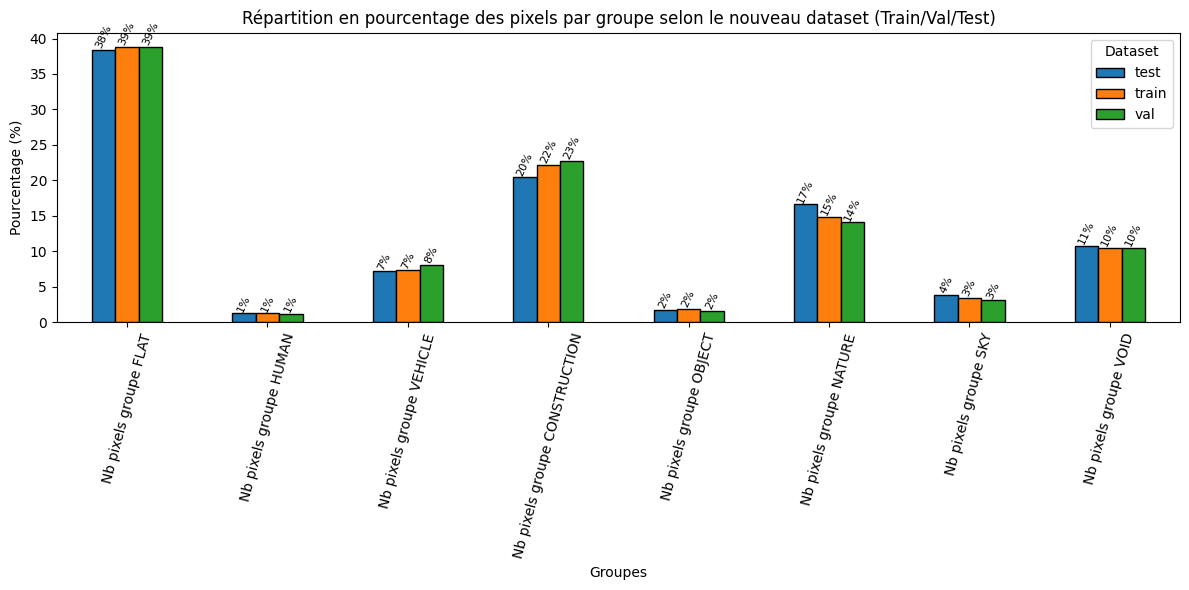

In [ ]:
#Affichage de l'équilibre des groupes sous forme d'histogramme


#Colonnes des pixels
colonnesDesGroupes = [
    "Nb pixels groupe FLAT",
    "Nb pixels groupe HUMAN",
    "Nb pixels groupe VEHICLE",
    "Nb pixels groupe CONSTRUCTION",
    "Nb pixels groupe OBJECT",
    "Nb pixels groupe NATURE",
    "Nb pixels groupe SKY",
    "Nb pixels groupe VOID"
]

#Regroupement par "dataset"/"répertoire" (Train, Val, Test) et somme des pixels
pixelsParDataset = newDataframe.groupby("Répertoires")[colonnesDesGroupes].sum()

#Conversion en pourcentages par "Répertoire"
pixelsPourcents = pixelsParDataset.div(pixelsParDataset.sum(axis=1), axis=0) * 100

#Histogramme
histo = pixelsPourcents.T.plot(kind="bar", figsize=(12, 6), edgecolor="black")
matplotlib.pyplot.title("Répartition en pourcentage des pixels par groupe selon le nouveau dataset (Train/Val/Test)")
matplotlib.pyplot.ylabel("Pourcentage (%)")
matplotlib.pyplot.xlabel("Groupes")
matplotlib.pyplot.xticks(rotation=75)
matplotlib.pyplot.legend(title="Dataset")
matplotlib.pyplot.tight_layout()
#Ajout des pourcentages au-dessus de chaque barre
for prct in histo.patches:
    height = prct.get_height()
    if(height > 0): #On va éviter d'écrire 0% sur les barres vides... Déjà parce que c'est "moyen utile", mais aussi parce que c'est juste moche, soyons francs ! :p
        histo.annotate(f"{height:.0f}%", (prct.get_x() + prct.get_width() / 2, height), ha="center", va="bottom", fontsize=8, rotation=65)
matplotlib.pyplot.show()

In [ ]:
newDataframe.to_csv("/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_Dataset.csv", index=False, sep=";")

Clairement, on n'est pas mal ! :)

L'équilibrage des groupes est conservé entre les différents dataset (train/test et val), avec un maximum de 3% d'écart.

# Partie 4 : création du Worflow

L'idée est de créer un workflow complet, du style :

<font color="#00FF00">Images</font>  **<font color="#FF0000">>>></font>**  <font color="#0000FF">Data-Generator</font> + <font color="#0000FF">Data-Augmentation</font> (*Albumentations*)  **<font color="#FF0000">>>></font>**  <font color="#0000FF">Modèle</font> (*Unet mini* / *VGG16 Unet*)  **<font color="#FF0000">>>></font>**  <font color="#00FF00">Masque de segmentation</font>


- **Data-Generator** : va créer des batchs d'images et alimenter nos modèles au fil de l'eau (sans charger toutes les images en mémoire)
- **Data-Augmentation** <font color="#FF0000">uniquement sur les données "train"</font> : va faire subir aux couples "images+masques", divers déformations (zooms, rotations, ...) afin d'éviter au modèle d'overfitter
- **Modèle** : on va utiliser 2 modèles : un 1er modèle simple *à entraîner* (Unet mini) et un 2ème modèle *pré-entraîné* (UNet avec VGG16 backbone), qui devront prédire un masque de segmentation d'image --> Modèles et métriques seront enregistrés dans MLflow

## 4.1 : data-generator + data-augmentation (Albumentations)

In [4]:
#Imports Partie 4.1
import os
from google.colab import drive
import numpy
import cv2
import albumentations
from PIL import Image
import tensorflow
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot

In [5]:
#WORKFLOW, PARTIE DATA-GENERATOR + DATA-AUGMENTATION


#Connexion à Google Drive
drive.mount("/content/drive/")

#Etape 1 : définition des chemins d'accès aux données nécessaires aux phases "train"/"val"/"test"
repertoireRacine = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_dataset"
repertoireTrain = os.path.join(repertoireRacine, "train")
repertoireVal   = os.path.join(repertoireRacine, "val")
repertoireTest  = os.path.join(repertoireRacine, "test")

#Etape 2 : récupération des fichiers images et masques
def _chargementListeImages(folder):
    listeFichiersImages  = sorted([os.path.join(folder, fichier) for fichier in os.listdir(folder) if fichier.endswith("_leftImg8bit.png")])
    listeFichiersMasques = sorted([os.path.join(folder, fichier) for fichier in os.listdir(folder) if fichier.endswith("_gtFine_labelIds.png")])
    return listeFichiersImages, listeFichiersMasques

imagesTrain, masquesTrain = _chargementListeImages(repertoireTrain)
imagesVal, masquesVal     = _chargementListeImages(repertoireVal)
imagesTest, masquesTest   = _chargementListeImages(repertoireTest)

#Etape 3 : mapping des classes
#Mapping IDs (au nombre de 34) par Classe (au nombre de 8)
# --> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
mappingDesClasses = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,              #void
    7: 1, 8: 1, 9: 1, 10: 1,                               #flat
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,              #construction
    17: 3, 18: 3, 19: 3, 20: 3,                            #object
    21: 4, 22: 4,                                          #nature
    23: 5,                                                 #sky
    24: 6, 25: 6,                                          #human
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7 #vehicle
}

#Etape 4 : data-generator & data-augmentation (Albumentations)
class SegmentationDataGenerator(Sequence):
    def __init__(self, emplacementImages, emplacementMasques, tailleBatch=8, tailleImage=(512, 1024), mode="train", melange=True):
        self.emplacementImages = emplacementImages
        self.emplacementMasques = emplacementMasques
        self.tailleBatch = tailleBatch
        self.tailleImage = tailleImage
        self.mode = mode
        self.melange = melange
        self.on_epoch_end()

        #Transformations
        #Si on est en "train" : data-augmentation !
        if self.mode == "train":
            self.transform = albumentations.Compose([
#COMMENTER/DECOMMENTER LES LIGNES CI-DESSOUS POUR DESACTIVER/ACTIVER LA DATA AUGMENTATION
#                albumentations.HorizontalFlip(p=0.5),
#                albumentations.VerticalFlip(p=0),   #Car, à part à installer la caméra à l'envers... le souci n'est plus l'informatique...
#                albumentations.RandomRotate90(p=0), #Idem : si on voit l'image à 90°, c'est qu'on fait des tonneaux...
#                albumentations.Affine(
#                    translate_percent={"x": 0.1, "y": 0.1},   #Décalage
#                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, #Zoom
#                    rotate=(-10, 10),                         #Rotation max 10°
#                    p=0.5                                     #50% du temps
#                ),
#                albumentations.RandomBrightnessContrast(p=0.2),
#COMMENTER/DECOMMENTER LES LIGNES CI-DESSUS POUR DESACTIVER/ACTIVER LA DATA AUGMENTATION
                albumentations.Resize(tailleImage[0], tailleImage[1])
            ])
        #Si on est en "val" ou "test" : pas besoin de data-augmentation (juste redimension)
        else:
            self.transform = albumentations.Compose([albumentations.Resize(tailleImage[0], tailleImage[1])])

    def __len__(self):
        return int(numpy.ceil(len(self.emplacementImages) / self.tailleBatch))

    def __getitem__(self, index):
        emplacementBatchImages = self.emplacementImages[index * self.tailleBatch:(index + 1) * self.tailleBatch]
        emplacementBatchMasques = self.emplacementMasques[index * self.tailleBatch:(index + 1) * self.tailleBatch]
        images  = []
        masques = []
        for cheminCompletImage, cheminCompletMasque in zip(emplacementBatchImages, emplacementBatchMasques):
            #Lecture de l'image
            image = cv2.imread(cheminCompletImage)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #Lecture du masque
            masque = cv2.imread(cheminCompletMasque, cv2.IMREAD_GRAYSCALE)
            #Transformation
            augmente = self.transform(image=image, mask=masque)
            imageAugmentee = augmente["image"] / 255
            masqueAugmente = augmente["mask"]
            #Mapping des classes (de 0 à 7)
            masque_mapped = numpy.zeros_like(masqueAugmente, dtype=numpy.int32)
            for trainId, classIndex in mappingDesClasses.items():
                masque_mapped[masqueAugmente == trainId] = classIndex
            #One-hot encoding (pour réduire les 34 classes en 8 classes "primaires")
            masques.append(to_categorical(masque_mapped, num_classes=8))
            images.append(imageAugmentee)
        return numpy.array(images, dtype=numpy.float32), numpy.array(masques, dtype=numpy.float32)

    def on_epoch_end(self):
        if self.melange and self.mode == "train":
            listeTemporaire = list(zip(self.emplacementImages, self.emplacementMasques))
            numpy.random.shuffle(listeTemporaire)

#Etape 5 : création des générateurs pour le modèle UNET
#generateurTrain = SegmentationDataGenerator(imagesTrain, masquesTrain, tailleBatch=64, tailleImage=(512, 1024), mode="train") #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM
#generateurVal   = SegmentationDataGenerator(imagesVal, masquesVal, tailleBatch=64, tailleImage=(512, 1024), mode="val")       #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM
#generateurTest  = SegmentationDataGenerator(imagesTest, masquesTest, tailleBatch=64, tailleImage=(512, 1024), mode="test")    #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM

#Etape 6 : test rapide, juste pour voir si tout est OK avec le modèle UNET
#X, y = generateurTrain[0]
#print("\n\nBatchs d'images   (normalement : batchs de 64 images, définition 512x1024 (HxW), en 3 canaux RGB)\t\t:", X.shape,
#      "\nBatchs de masques (normalement : batchs de 64 images, définition 512x1024 (HxW), en 8 classes \"primaires\")\t:", y.shape)

#Etape 5 : création des générateurs pour le modèle VGG16+UNET
generateurTrain = SegmentationDataGenerator(imagesTrain, masquesTrain, tailleBatch=64, tailleImage=(224, 224), mode="train") #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM
generateurVal   = SegmentationDataGenerator(imagesVal, masquesVal, tailleBatch=64, tailleImage=(224, 224), mode="val")       #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM
generateurTest  = SegmentationDataGenerator(imagesTest, masquesTest, tailleBatch=64, tailleImage=(224, 224), mode="test")    #Vu la lenteur lors du 1er entraînement, passage de 8 images/batch à 64. Testé sur GPU A100 : pas de OOM

#Etape 6 : test rapide, juste pour voir si tout est OK avec le modèle VGG16+UNET
X, y = generateurTrain[0]
print("\n\nBatchs d'images   (normalement : batchs de 64 images, définition 224x224 (HxW), en 3 canaux RGB)\t\t:", X.shape,
      "\nBatchs de masques (normalement : batchs de 64 images, définition 224x224 (HxW), en 8 classes \"primaires\")\t:", y.shape)

Mounted at /content/drive/


Batchs d'images   (normalement : batchs de 64 images, définition 224x224 (HxW), en 3 canaux RGB)		: (64, 224, 224, 3) 
Batchs de masques (normalement : batchs de 64 images, définition 224x224 (HxW), en 8 classes "primaires")	: (64, 224, 224, 8)


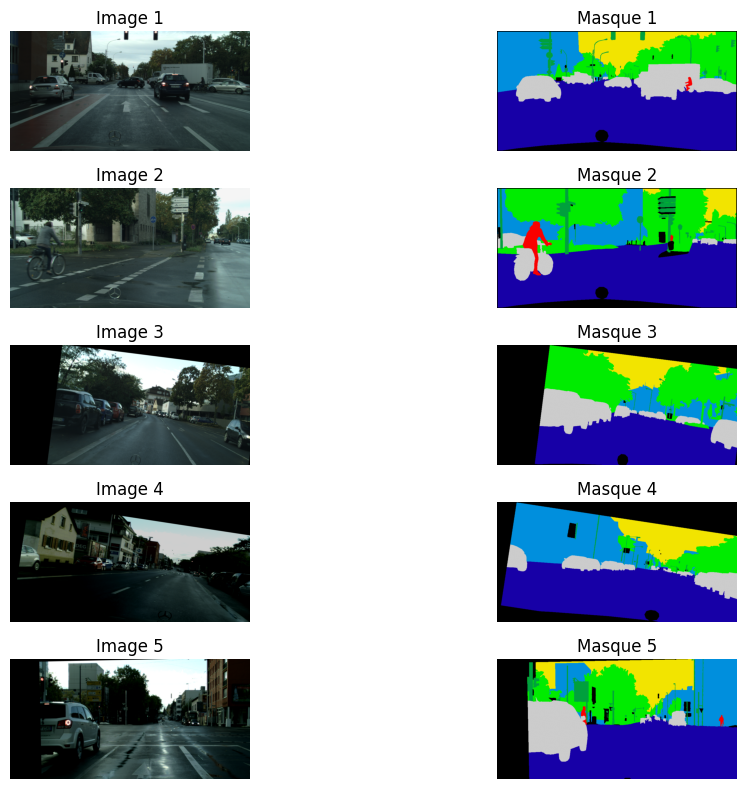

In [ ]:
#TEST DONNEES TRAIN AVEC DATA AUGMENTATION


#On récupère le batch n°7, par exemple
batchImage, batchMasque = generateurTrain[7]

#Nombre d'images à afficher
nbImageAfficher = 5

matplotlib.pyplot.figure(figsize=(12, 8))
for i in range(nbImageAfficher):
    #Image
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+1)
    matplotlib.pyplot.imshow(batchImage[i])
    matplotlib.pyplot.title(f"Image {i+1}")
    matplotlib.pyplot.axis("Off")
    #Masque
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+2)

    #Type "ColorMaps"
    masqueOneHot = numpy.argmax(batchMasque[i], axis=-1)
    matplotlib.pyplot.imshow(masqueOneHot, cmap="nipy_spectral", vmin=0, vmax=7)

    #Type "Nuances de gris"
    #masqueClasses = numpy.argmax(batchMasque[i], axis=-1) #Valeurs de 0 à 7 (les classes)
    #masqueNuancesDeGris = masqueClasses / (batchMasque.shape[-1] - 1) #Normalisation entre 0 et 1
    #matplotlib.pyplot.imshow(masqueNuancesDeGris, cmap="gray")

    matplotlib.pyplot.title(f"Masque {i+1}")
    matplotlib.pyplot.axis("Off")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

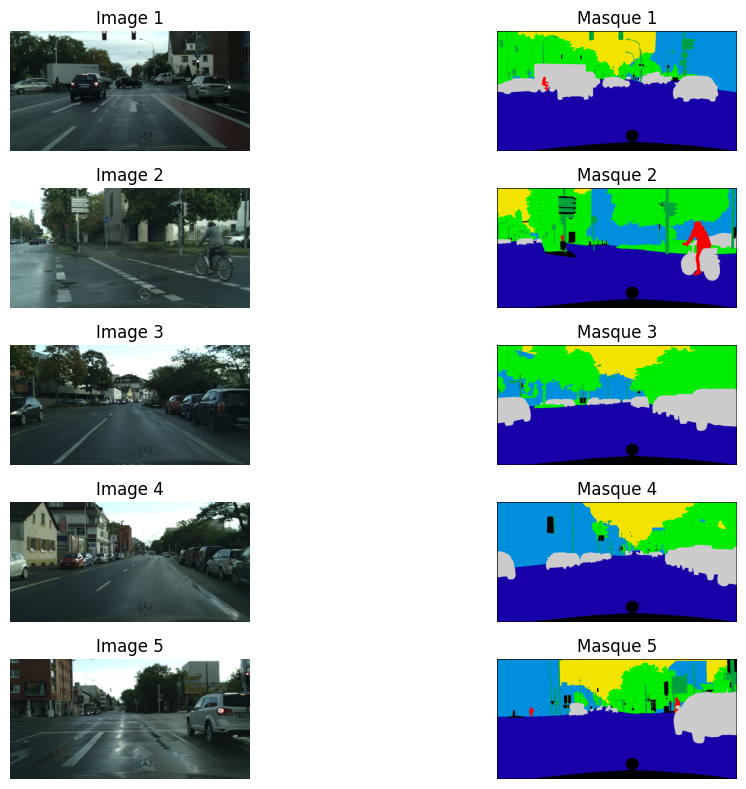

In [ ]:
#TEST DONNEES TRAIN SANS DATA AUGMENTATION


#On récupère le batch n°7, par exemple
batchImage, batchMasque = generateurTrain[7]

#Nombre d'images à afficher
nbImageAfficher = 5

matplotlib.pyplot.figure(figsize=(12, 8))
for i in range(nbImageAfficher):
    #Image
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+1)
    matplotlib.pyplot.imshow(batchImage[i])
    matplotlib.pyplot.title(f"Image {i+1}")
    matplotlib.pyplot.axis("Off")
    #Masque
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+2)

    #Type "ColorMaps"
    masqueOneHot = numpy.argmax(batchMasque[i], axis=-1)
    matplotlib.pyplot.imshow(masqueOneHot, cmap="nipy_spectral", vmin=0, vmax=7)

    #Type "Nuances de gris"
    #masqueClasses = numpy.argmax(batchMasque[i], axis=-1) #Valeurs de 0 à 7 (les classes)
    #masqueNuancesDeGris = masqueClasses / (batchMasque.shape[-1] - 1) #Normalisation entre 0 et 1
    #matplotlib.pyplot.imshow(masqueNuancesDeGris, cmap="gray")

    matplotlib.pyplot.title(f"Masque {i+1}")
    matplotlib.pyplot.axis("Off")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

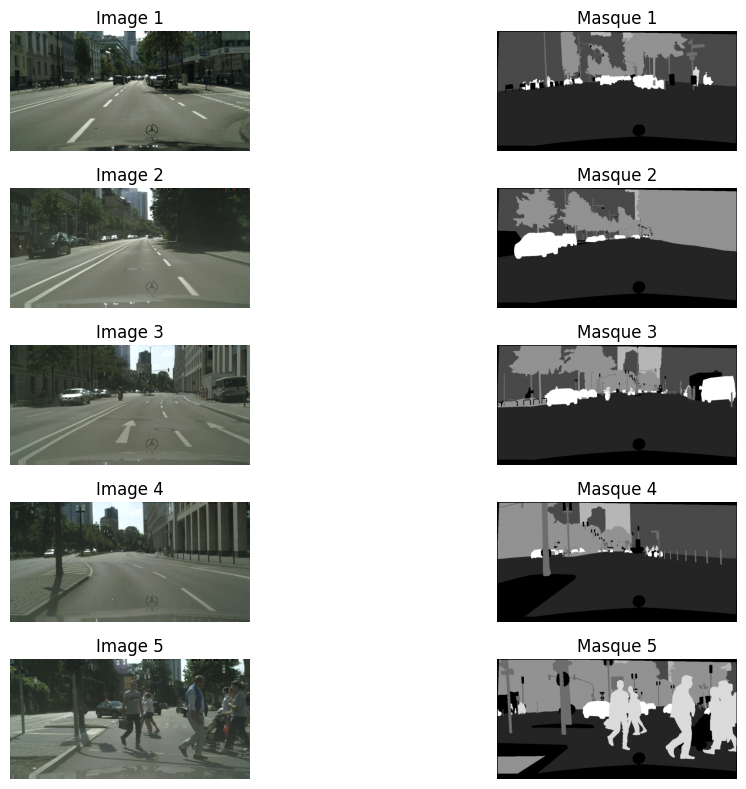

In [ ]:
#TEST DONNEES VAL


#On récupère le batch n°2, par exemple
batchImage, batchMasque = generateurVal[2]

#Nombre d'images à afficher
nbImageAfficher = 5

matplotlib.pyplot.figure(figsize=(12, 8))
for i in range(nbImageAfficher):
    #Image
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+1)
    matplotlib.pyplot.imshow(batchImage[i])
    matplotlib.pyplot.title(f"Image {i+1}")
    matplotlib.pyplot.axis("Off")
    #Masque
    matplotlib.pyplot.subplot(nbImageAfficher, 2, 2*i+2)

    #Type "ColorMaps"
    #masqueOneHot = numpy.argmax(batchMasque[i], axis=-1)
    #matplotlib.pyplot.imshow(masqueOneHot, cmap="nipy_spectral", vmin=0, vmax=7)

    #Type "Nuances de gris"
    masqueClasses = numpy.argmax(batchMasque[i], axis=-1) #Valeurs de 0 à 7 (les classes)
    masqueNuancesDeGris = masqueClasses / (batchMasque.shape[-1] - 1) #Normalisation entre 0 et 1
    matplotlib.pyplot.imshow(masqueNuancesDeGris, cmap="gray")

    matplotlib.pyplot.title(f"Masque {i+1}")
    matplotlib.pyplot.axis("Off")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 4.2 : modèle (Unet mini)

In [ ]:
#Imports Partie 4.2
import tensorflow
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend

In [ ]:
#Création du modèle Unet mini


#Fonctions métriques
#Calcul du "Dice coefficient" (également appelé F1 score pour la segmentation) :
# Mesure la similarité entre deux ensembles (prédiction vs. réel), en mettant l’accent sur leur chevauchement.
# Utile en cas de contexte de classes déséquilibrées, car il double le poids de l’intersection.
#
#Interprétation :
# Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée
def coefDiceMulti(y_true, y_pred, smooth=1): #Calcul du Dice coefficient MOYEN sur toutes les classes
    y_true_f = tensorflow.keras.backend.reshape(y_true, (-1, 8)) #On transforme les tensors du masque réel (et ses 8 classes) en liste
    y_pred_f = tensorflow.keras.backend.reshape(y_pred, (-1, 8)) #On transforme les tensors du masque prédit (et ses 8 classes) en liste
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f, axis=0)
    sum_true_pred = tensorflow.keras.backend.sum(y_true_f, axis=0) + tensorflow.keras.backend.sum(y_pred_f, axis=0)
    dice_per_class = (2 * intersection + smooth) / (sum_true_pred + smooth)
    return tensorflow.keras.backend.mean(dice_per_class)

#Calcul de l'"Intersection Over Union coefficient" (IoU) :
# Evalue la qualité d’une prédiction en calculant le ratio entre l’intersection et l’union des ensembles prédits et réels.
# Pénalise plus fortement les erreurs de classification que le Dice.
#
#Interprétation :
# IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes
# IoU = 0,7..0,8 et + : excellente segmentation
# IoU = 0,5..0,6      : segmentation correcte
# IoU = <0,3          : segmentation pas terrible...
# IoU = 0             : aucune intersection (prédictions totalement fausses)
def coefIoUMulti(y_true, y_pred, smooth=1): #Calcul de l'IoU moyen sur toutes les classes
    y_true_f = tensorflow.keras.backend.reshape(y_true, (-1, 8))
    y_pred_f = tensorflow.keras.backend.reshape(y_pred, (-1, 8))
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f, axis=0)
    union = tensorflow.keras.backend.sum(y_true_f, axis=0) + tensorflow.keras.backend.sum(y_pred_f, axis=0) - intersection
    iou_per_class = (intersection + smooth) / (union + smooth)
    return tensorflow.keras.backend.mean(iou_per_class)


#Fonctions LOSS
def diceLoss(y_true, y_pred): #Loss Dice
    return 1 - coefDiceMulti(y_true, y_pred)

def balancedCrossEntropy(y_true, y_pred): #Loss CrossEntropy
    bce = tensorflow.keras.losses.CategoricalCrossentropy()
    return bce(y_true, y_pred)

def totalLoss(y_true, y_pred): #Loss combinée : Dice + Crossentropy
    return diceLoss(y_true, y_pred) + balancedCrossEntropy(y_true, y_pred)


#Définition des couches du modèle Unet mini
def creationModeleUnetMini(tailleImage=(512, 1024, 3)):
    inputs = Input(tailleImage)

    ##########
    #Encodeur# : compresse les données d’entrée en une représentation plus compacte
    ##########
    c1 = Conv2D(16, (3,3), activation="relu", padding="same")(inputs) #...
    c1 = Conv2D(16, (3,3), activation="relu", padding="same")(c1)     #2 couches de CONVOLUTION pour l'encodeur (but : trouver/reconnaître des patterns dans l'image)
    p1 = MaxPooling2D((2,2))(c1)                                      #Couche de POOLING (but : réduire la taille de l'image)

    c2 = Conv2D(32, (3,3), activation="relu", padding="same")(p1)     #...
    c2 = Conv2D(32, (3,3), activation="relu", padding="same")(c2)     #2 couches de CONVOLUTION pour l'encodeur (but : trouver/reconnaître des patterns dans l'image)
    p2 = MaxPooling2D((2,2))(c2)                                      #Couche de POOLING (but : réduire la taille de l'image)

    c3 = Conv2D(64, (3,3), activation="relu", padding="same")(p2)     #...
    c3 = Conv2D(64, (3,3), activation="relu", padding="same")(c3)     #2 couches de CONVOLUTION pour l'encodeur (but : trouver/reconnaître des patterns dans l'image)
    p3 = MaxPooling2D((2,2))(c3)                                      #Couche de POOLING (but : réduire la taille de l'image)

    #######################
    #Goulot d’étranglement# : extrait les carac. les plus abstraites de l’image (beaucoup d’info globale, mais peu de détails fins) ; C'est la couche la plus profonde du réseau de neurones
    #######################
    c4 = Conv2D(128, (3,3), activation="relu", padding="same")(p3)    #...
    c4 = Conv2D(128, (3,3), activation="relu", padding="same")(c4)    #2 couches de CONVOLUTION pour l'encodeur (but : trouver/reconnaître des patterns dans l'image)

    ##########
    #Décodeur# : reconstruit les données originales à partir de la représentation compacte issue de la couche de Bottleneck
    ##########
    u5 = UpSampling2D((2,2))(c4)                                      #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u5 = concatenate([u5, c3])                                        #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c5 = Conv2D(64, (3,3), activation="relu", padding="same")(u5)     #...
    c5 = Conv2D(64, (3,3), activation="relu", padding="same")(c5)     #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    u6 = UpSampling2D((2,2))(c5)                                      #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u6 = concatenate([u6, c2])                                        #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c6 = Conv2D(32, (3,3), activation="relu", padding="same")(u6)     #...
    c6 = Conv2D(32, (3,3), activation="relu", padding="same")(c6)     #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    u7 = UpSampling2D((2,2))(c6)                                      #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u7 = concatenate([u7, c1])                                        #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c7 = Conv2D(16, (3,3), activation="relu", padding="same")(u7)     #...
    c7 = Conv2D(16, (3,3), activation="relu", padding="same")(c7)     #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    outputs = Conv2D(8, (1,1), activation="softmax")(c7)              #Dernière couche (but : couche de prédiction multi-classes pour les 8 catégories)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


#Instanciation du modèle
model_UnetMini = creationModeleUnetMini(tailleImage=(512, 1024, 3))

#Choix de la LOSS, entre : diceLoss, balancedCrossEntropy ou totalLoss #J'essaierai d'en tester plusieurs si l'entraînement ne dure pas trop longtemps...
choixDeLaLoss = balancedCrossEntropy

#Compilation : optimiseur Adam + loss choisie + métriques personnalisées
model_UnetMini.compile(optimizer="adam", loss=choixDeLaLoss, metrics=["accuracy", coefDiceMulti, coefIoUMulti])  #En cas d'overfit, je testerai AdamW (voire RAdam, si j'ai le temps... Ca commence à faire beaucoup de "Si" malheureusement...)
model_UnetMini.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 1024, │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 1024, │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 512,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 512,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 512,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 256,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 256,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 256,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 128,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 128,   │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 128,   │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 256,  │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 256,  │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 512,  │          0 │ conv2d_9[0][0]  

 Total params: 487,416 (1.86 MB)

 Trainable params: 487,416 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2.1 : entraînement (Unet mini) - Avec/Sans Data-Augmentation

In [ ]:
#Imports Partie 4.2.1
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
#ENTRAÎNEMENT

#Etape 1 : définition du chemin de sauvegarde du meilleur modèle
#cheminMeilleurModel = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini.keras"
cheminMeilleurModel = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras"

#Etape 2 : Callbacks/EarlyStopping
checkPointModel = ModelCheckpoint(filepath=cheminMeilleurModel, monitor="val_loss", save_best_only=True, mode="min", verbose=1)
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1, restore_best_weights=True)
listCallbacks = [checkPointModel, earlyStopping]

#Etape 3 : entraînement du modèle
nbEpochs = 100 #A raison de 10 min par EPOCH sur un A100 (qui coûte une blinde), je risque fort d'avoir à vendre un rein... Espérons qu'on convergera rapidement...

mlflow.set_experiment("Image_Segmentation")
mlflow.tensorflow.autolog()
#with mlflow.start_run(run_name="UnetMini"):
with mlflow.start_run(run_name="UnetMini_sans_DataAugmentation"):
#    mlflow.log_param("preprocessing_type", "Resize images 50% + Data-augmentation (Albumentations)")
    mlflow.log_param("preprocessing_type", "Resize images 50%")
#    mlflow.set_tag("model_type", "UnetMini")
    mlflow.set_tag("model_type", "UnetMini_sans_DataAugmentation")
    history = model_UnetMini.fit(generateurTrain, validation_data=generateurVal, epochs=nbEpochs, callbacks=listCallbacks, verbose=1)

    #Sauvegarde du MEILLEUR modèle dans MLflow
    print("Sauvegarde du modèle dans MLflow...")
#    mlflow.log_artifact(cheminMeilleurModel, artifact_path="UnetMini")
    mlflow.log_artifact(cheminMeilleurModel, artifact_path="UnetMini_sans_DataAugmentation")

mlflow.end_run()

2025/09/26 09:15:02 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.SegmentationDataGenerator'>. Dataset logging skipped.
2025/09/26 09:15:02 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.SegmentationDataGenerator'>. Dataset logging skipped.
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1961 - coef_dice_multi: 0.1050 - coef_io_u_multi: 0.0571 - loss: 1.9733 
Epoch 1: val_loss improved from inf to 1.63482, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 1633s 46s/step - accuracy: 0.1983 - coef_dice_multi: 0.1052 - coef_io_u_multi: 0.0573 - loss: 1.9695 - val_accuracy: 0.3909 - val_coef_dice_multi: 0.1309 - val_coef_io_u_multi: 0.0737 - val_loss: 1.6348
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3922 - coef_dice_multi: 0.1386 - coef_io_u_multi: 0.0791 - loss: 1.6196
Epoch 2: val_loss improved from 1.63482 to 1.54615, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.3923 - coef_dice_multi: 0.1386 - coef_io_u_multi: 0.0792 - loss: 1.6195 - val_accuracy: 0.4028 - val_coef_dice_multi: 0.1507 - val_coef_io_u_multi: 0.0866 - val_loss: 1.5462
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4058 - coef_dice_multi: 0.1641 - coef_io_u_multi: 0.0973 - loss: 1.5199
Epoch 3: val_loss improved from 1.54615 to 1.42602, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.4062 - coef_dice_multi: 0.1646 - coef_io_u_multi: 0.0977 - loss: 1.5187 - val_accuracy: 0.4218 - val_coef_dice_multi: 0.1815 - val_coef_io_u_multi: 0.1080 - val_loss: 1.4260
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4394 - coef_dice_multi: 0.2194 - coef_io_u_multi: 0.1370 - loss: 1.3947
Epoch 4: val_loss improved from 1.42602 to 1.30756, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 332s 10s/step - accuracy: 0.4397 - coef_dice_multi: 0.2195 - coef_io_u_multi: 0.1371 - loss: 1.3945 - val_accuracy: 0.5266 - val_coef_dice_multi: 0.2261 - val_coef_io_u_multi: 0.1417 - val_loss: 1.3076
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5001 - coef_dice_multi: 0.2275 - coef_io_u_multi: 0.1435 - loss: 1.3596
Epoch 5: val_loss improved from 1.30756 to 1.23937, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 339s 10s/step - accuracy: 0.5007 - coef_dice_multi: 0.2277 - coef_io_u_multi: 0.1437 - loss: 1.3583 - val_accuracy: 0.5648 - val_coef_dice_multi: 0.2404 - val_coef_io_u_multi: 0.1519 - val_loss: 1.2394
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5609 - coef_dice_multi: 0.2391 - coef_io_u_multi: 0.1536 - loss: 1.2559
Epoch 6: val_loss improved from 1.23937 to 1.11675, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 337s 10s/step - accuracy: 0.5614 - coef_dice_multi: 0.2397 - coef_io_u_multi: 0.1540 - loss: 1.2546 - val_accuracy: 0.6191 - val_coef_dice_multi: 0.2919 - val_coef_io_u_multi: 0.1944 - val_loss: 1.1168
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6089 - coef_dice_multi: 0.2955 - coef_io_u_multi: 0.1989 - loss: 1.1485
Epoch 7: val_loss did not improve from 1.11675
33/33 ━━━━━━━━━━━━━━━━━━━━ 334s 10s/step - accuracy: 0.6089 - coef_dice_multi: 0.2953 - coef_io_u_multi: 0.1988 - loss: 1.1488 - val_accuracy: 0.6101 - val_coef_dice_multi: 0.2937 - val_coef_io_u_multi: 0.1956 - val_loss: 1.1248
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6209 - coef_dice_multi: 0.3049 - coef_io_u_multi: 0.2053 - loss: 1.1279
Epoch 8: val_loss improved from 1.11675 to 1.07579, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 343s 10s/step - accuracy: 0.6213 - coef_dice_multi: 0.3053 - coef_io_u_multi: 0.2056 - loss: 1.1266 - val_accuracy: 0.6481 - val_coef_dice_multi: 0.3351 - val_coef_io_u_multi: 0.2308 - val_loss: 1.0758
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6651 - coef_dice_multi: 0.3517 - coef_io_u_multi: 0.2441 - loss: 1.0174
Epoch 9: val_loss improved from 1.07579 to 0.88524, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 339s 10s/step - accuracy: 0.6656 - coef_dice_multi: 0.3521 - coef_io_u_multi: 0.2444 - loss: 1.0164 - val_accuracy: 0.7115 - val_coef_dice_multi: 0.4009 - val_coef_io_u_multi: 0.2881 - val_loss: 0.8852
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6814 - coef_dice_multi: 0.3865 - coef_io_u_multi: 0.2759 - loss: 0.9509
Epoch 10: val_loss did not improve from 0.88524
33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.6817 - coef_dice_multi: 0.3866 - coef_io_u_multi: 0.2760 - loss: 0.9501 - val_accuracy: 0.7056 - val_coef_dice_multi: 0.4057 - val_coef_io_u_multi: 0.2936 - val_loss: 0.9166
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7082 - coef_dice_multi: 0.4073 - coef_io_u_multi: 0.2961 - loss: 0.9030
Epoch 11: val_loss improved from 0.88524 to 0.85783, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.7083 - coef_dice_multi: 0.4073 - coef_io_u_multi: 0.2961 - loss: 0.9028 - val_accuracy: 0.7196 - val_coef_dice_multi: 0.4167 - val_coef_io_u_multi: 0.3031 - val_loss: 0.8578
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7165 - coef_dice_multi: 0.4230 - coef_io_u_multi: 0.3111 - loss: 0.8643
Epoch 12: val_loss improved from 0.85783 to 0.83826, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 336s 10s/step - accuracy: 0.7165 - coef_dice_multi: 0.4228 - coef_io_u_multi: 0.3109 - loss: 0.8646 - val_accuracy: 0.7229 - val_coef_dice_multi: 0.4274 - val_coef_io_u_multi: 0.3149 - val_loss: 0.8383
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7322 - coef_dice_multi: 0.4281 - coef_io_u_multi: 0.3161 - loss: 0.8241
Epoch 13: val_loss improved from 0.83826 to 0.78058, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 336s 10s/step - accuracy: 0.7322 - coef_dice_multi: 0.4282 - coef_io_u_multi: 0.3162 - loss: 0.8239 - val_accuracy: 0.7438 - val_coef_dice_multi: 0.4391 - val_coef_io_u_multi: 0.3246 - val_loss: 0.7806
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7352 - coef_dice_multi: 0.4393 - coef_io_u_multi: 0.3273 - loss: 0.7995
Epoch 14: val_loss did not improve from 0.78058
33/33 ━━━━━━━━━━━━━━━━━━━━ 338s 10s/step - accuracy: 0.7351 - coef_dice_multi: 0.4393 - coef_io_u_multi: 0.3273 - loss: 0.7997 - val_accuracy: 0.7373 - val_coef_dice_multi: 0.4138 - val_coef_io_u_multi: 0.2970 - val_loss: 0.7956
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7428 - coef_dice_multi: 0.4401 - coef_io_u_multi: 0.3269 - loss: 0.7840
Epoch 15: val_loss improved from 0.78058 to 0.77212, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 335s 10s/step - accuracy: 0.7428 - coef_dice_multi: 0.4403 - coef_io_u_multi: 0.3272 - loss: 0.7840 - val_accuracy: 0.7467 - val_coef_dice_multi: 0.4566 - val_coef_io_u_multi: 0.3418 - val_loss: 0.7721
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7444 - coef_dice_multi: 0.4533 - coef_io_u_multi: 0.3409 - loss: 0.7897
Epoch 16: val_loss improved from 0.77212 to 0.74818, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.7445 - coef_dice_multi: 0.4533 - coef_io_u_multi: 0.3408 - loss: 0.7894 - val_accuracy: 0.7570 - val_coef_dice_multi: 0.4658 - val_coef_io_u_multi: 0.3551 - val_loss: 0.7482
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7466 - coef_dice_multi: 0.4584 - coef_io_u_multi: 0.3470 - loss: 0.7778
Epoch 17: val_loss improved from 0.74818 to 0.74265, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.7467 - coef_dice_multi: 0.4584 - coef_io_u_multi: 0.3470 - loss: 0.7773 - val_accuracy: 0.7601 - val_coef_dice_multi: 0.4682 - val_coef_io_u_multi: 0.3551 - val_loss: 0.7427
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7509 - coef_dice_multi: 0.4587 - coef_io_u_multi: 0.3453 - loss: 0.7703
Epoch 18: val_loss did not improve from 0.74265
33/33 ━━━━━━━━━━━━━━━━━━━━ 340s 10s/step - accuracy: 0.7508 - coef_dice_multi: 0.4586 - coef_io_u_multi: 0.3452 - loss: 0.7705 - val_accuracy: 0.7373 - val_coef_dice_multi: 0.4274 - val_coef_io_u_multi: 0.3105 - val_loss: 0.8052
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7587 - coef_dice_multi: 0.4617 - coef_io_u_multi: 0.3468 - loss: 0.7520
Epoch 19: val_loss improved from 0.74265 to 0.68754, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 338s 10s/step - accuracy: 0.7590 - coef_dice_multi: 0.4620 - coef_io_u_multi: 0.3471 - loss: 0.7513 - val_accuracy: 0.7812 - val_coef_dice_multi: 0.4839 - val_coef_io_u_multi: 0.3686 - val_loss: 0.6875
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7703 - coef_dice_multi: 0.4753 - coef_io_u_multi: 0.3610 - loss: 0.7185
Epoch 20: val_loss did not improve from 0.68754
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.7702 - coef_dice_multi: 0.4751 - coef_io_u_multi: 0.3608 - loss: 0.7190 - val_accuracy: 0.7658 - val_coef_dice_multi: 0.4749 - val_coef_io_u_multi: 0.3584 - val_loss: 0.7253
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7783 - coef_dice_multi: 0.4841 - coef_io_u_multi: 0.3690 - loss: 0.6957
Epoch 21: val_loss did not improve from 0.68754
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.7782 - coef_dice_multi: 0.4841 - coef_io_u_multi: 0.3691 - loss: 0.6957 - val_accuracy: 0.7669 - val_coef_dice_multi:

33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.7835 - coef_dice_multi: 0.4874 - coef_io_u_multi: 0.3744 - loss: 0.6758 - val_accuracy: 0.7942 - val_coef_dice_multi: 0.5066 - val_coef_io_u_multi: 0.3906 - val_loss: 0.6412
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7912 - coef_dice_multi: 0.5066 - coef_io_u_multi: 0.3914 - loss: 0.6547
Epoch 23: val_loss did not improve from 0.64124
33/33 ━━━━━━━━━━━━━━━━━━━━ 343s 10s/step - accuracy: 0.7910 - coef_dice_multi: 0.5065 - coef_io_u_multi: 0.3912 - loss: 0.6551 - val_accuracy: 0.7812 - val_coef_dice_multi: 0.4858 - val_coef_io_u_multi: 0.3702 - val_loss: 0.6743
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7771 - coef_dice_multi: 0.4878 - coef_io_u_multi: 0.3716 - loss: 0.6924
Epoch 24: val_loss did not improve from 0.64124
33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.7772 - coef_dice_multi: 0.4879 - coef_io_u_multi: 0.3717 - loss: 0.6923 - val_accuracy: 0.7810 - val_coef_dice_multi:

33/33 ━━━━━━━━━━━━━━━━━━━━ 340s 10s/step - accuracy: 0.7954 - coef_dice_multi: 0.5095 - coef_io_u_multi: 0.3936 - loss: 0.6427 - val_accuracy: 0.8109 - val_coef_dice_multi: 0.5304 - val_coef_io_u_multi: 0.4147 - val_loss: 0.5993
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8000 - coef_dice_multi: 0.5250 - coef_io_u_multi: 0.4096 - loss: 0.6258
Epoch 27: val_loss did not improve from 0.59928
33/33 ━━━━━━━━━━━━━━━━━━━━ 340s 10s/step - accuracy: 0.8001 - coef_dice_multi: 0.5250 - coef_io_u_multi: 0.4095 - loss: 0.6256 - val_accuracy: 0.8073 - val_coef_dice_multi: 0.5299 - val_coef_io_u_multi: 0.4134 - val_loss: 0.6058
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8044 - coef_dice_multi: 0.5246 - coef_io_u_multi: 0.4089 - loss: 0.6148
Epoch 28: val_loss did not improve from 0.59928
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8045 - coef_dice_multi: 0.5246 - coef_io_u_multi: 0.4090 - loss: 0.6148 - val_accuracy: 0.8060 - val_coef_dice_multi:

33/33 ━━━━━━━━━━━━━━━━━━━━ 337s 10s/step - accuracy: 0.8082 - coef_dice_multi: 0.5323 - coef_io_u_multi: 0.4160 - loss: 0.6063 - val_accuracy: 0.8202 - val_coef_dice_multi: 0.5448 - val_coef_io_u_multi: 0.4284 - val_loss: 0.5686
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8139 - coef_dice_multi: 0.5378 - coef_io_u_multi: 0.4214 - loss: 0.5904
Epoch 30: val_loss did not improve from 0.56860
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8140 - coef_dice_multi: 0.5380 - coef_io_u_multi: 0.4216 - loss: 0.5900 - val_accuracy: 0.8133 - val_coef_dice_multi: 0.5507 - val_coef_io_u_multi: 0.4339 - val_loss: 0.5887
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8057 - coef_dice_multi: 0.5347 - coef_io_u_multi: 0.4190 - loss: 0.6027
Epoch 31: val_loss did not improve from 0.56860
33/33 ━━━━━━━━━━━━━━━━━━━━ 339s 10s/step - accuracy: 0.8051 - coef_dice_multi: 0.5340 - coef_io_u_multi: 0.4183 - loss: 0.6045 - val_accuracy: 0.7640 - val_coef_dice_multi:

33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8226 - coef_dice_multi: 0.5526 - coef_io_u_multi: 0.4369 - loss: 0.5616 - val_accuracy: 0.8222 - val_coef_dice_multi: 0.5569 - val_coef_io_u_multi: 0.4401 - val_loss: 0.5624
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8202 - coef_dice_multi: 0.5544 - coef_io_u_multi: 0.4380 - loss: 0.5695
Epoch 35: val_loss improved from 0.56236 to 0.53185, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8202 - coef_dice_multi: 0.5544 - coef_io_u_multi: 0.4381 - loss: 0.5694 - val_accuracy: 0.8318 - val_coef_dice_multi: 0.5642 - val_coef_io_u_multi: 0.4499 - val_loss: 0.5318
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8290 - coef_dice_multi: 0.5642 - coef_io_u_multi: 0.4485 - loss: 0.5350
Epoch 36: val_loss did not improve from 0.53185
33/33 ━━━━━━━━━━━━━━━━━━━━ 343s 10s/step - accuracy: 0.8289 - coef_dice_multi: 0.5642 - coef_io_u_multi: 0.4485 - loss: 0.5352 - val_accuracy: 0.8275 - val_coef_dice_multi: 0.5539 - val_coef_io_u_multi: 0.4338 - val_loss: 0.5482
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8199 - coef_dice_multi: 0.5556 - coef_io_u_multi: 0.4375 - loss: 0.5609
Epoch 37: val_loss did not improve from 0.53185
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8200 - coef_dice_multi: 0.5556 - coef_io_u_multi: 0.4376 - loss: 0.5608 - val_accuracy: 0.8307 - val_coef_dice_multi:

33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8236 - coef_dice_multi: 0.5622 - coef_io_u_multi: 0.4453 - loss: 0.5498 - val_accuracy: 0.8402 - val_coef_dice_multi: 0.5880 - val_coef_io_u_multi: 0.4735 - val_loss: 0.5161
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8397 - coef_dice_multi: 0.5832 - coef_io_u_multi: 0.4678 - loss: 0.5042
Epoch 40: val_loss did not improve from 0.51612
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8396 - coef_dice_multi: 0.5831 - coef_io_u_multi: 0.4676 - loss: 0.5044 - val_accuracy: 0.8359 - val_coef_dice_multi: 0.5817 - val_coef_io_u_multi: 0.4650 - val_loss: 0.5223
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8429 - coef_dice_multi: 0.5889 - coef_io_u_multi: 0.4739 - loss: 0.4903
Epoch 41: val_loss improved from 0.51612 to 0.51259, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - accuracy: 0.8428 - coef_dice_multi: 0.5888 - coef_io_u_multi: 0.4737 - loss: 0.4908 - val_accuracy: 0.8378 - val_coef_dice_multi: 0.5811 - val_coef_io_u_multi: 0.4648 - val_loss: 0.5126
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8329 - coef_dice_multi: 0.5792 - coef_io_u_multi: 0.4626 - loss: 0.5229
Epoch 42: val_loss improved from 0.51259 to 0.48083, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - accuracy: 0.8330 - coef_dice_multi: 0.5793 - coef_io_u_multi: 0.4628 - loss: 0.5225 - val_accuracy: 0.8500 - val_coef_dice_multi: 0.5920 - val_coef_io_u_multi: 0.4772 - val_loss: 0.4808
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8429 - coef_dice_multi: 0.5873 - coef_io_u_multi: 0.4711 - loss: 0.4939
Epoch 43: val_loss did not improve from 0.48083
33/33 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.8429 - coef_dice_multi: 0.5874 - coef_io_u_multi: 0.4712 - loss: 0.4939 - val_accuracy: 0.8420 - val_coef_dice_multi: 0.5856 - val_coef_io_u_multi: 0.4702 - val_loss: 0.5049
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8426 - coef_dice_multi: 0.5954 - coef_io_u_multi: 0.4788 - loss: 0.4952
Epoch 44: val_loss improved from 0.48083 to 0.48052, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 343s 10s/step - accuracy: 0.8427 - coef_dice_multi: 0.5954 - coef_io_u_multi: 0.4788 - loss: 0.4948 - val_accuracy: 0.8488 - val_coef_dice_multi: 0.5944 - val_coef_io_u_multi: 0.4790 - val_loss: 0.4805
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8504 - coef_dice_multi: 0.5967 - coef_io_u_multi: 0.4830 - loss: 0.4724
Epoch 45: val_loss did not improve from 0.48052
33/33 ━━━━━━━━━━━━━━━━━━━━ 337s 10s/step - accuracy: 0.8503 - coef_dice_multi: 0.5966 - coef_io_u_multi: 0.4829 - loss: 0.4728 - val_accuracy: 0.8480 - val_coef_dice_multi: 0.5961 - val_coef_io_u_multi: 0.4795 - val_loss: 0.4847
Epoch 46/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8402 - coef_dice_multi: 0.5900 - coef_io_u_multi: 0.4730 - loss: 0.5038
Epoch 46: val_loss improved from 0.48052 to 0.47563, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.8403 - coef_dice_multi: 0.5902 - coef_io_u_multi: 0.4732 - loss: 0.5033 - val_accuracy: 0.8501 - val_coef_dice_multi: 0.5983 - val_coef_io_u_multi: 0.4800 - val_loss: 0.4756
Epoch 47/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8501 - coef_dice_multi: 0.5969 - coef_io_u_multi: 0.4813 - loss: 0.4759
Epoch 47: val_loss improved from 0.47563 to 0.46559, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 345s 10s/step - accuracy: 0.8500 - coef_dice_multi: 0.5968 - coef_io_u_multi: 0.4811 - loss: 0.4762 - val_accuracy: 0.8530 - val_coef_dice_multi: 0.6082 - val_coef_io_u_multi: 0.4946 - val_loss: 0.4656
Epoch 48/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8574 - coef_dice_multi: 0.6107 - coef_io_u_multi: 0.4961 - loss: 0.4512
Epoch 48: val_loss did not improve from 0.46559
33/33 ━━━━━━━━━━━━━━━━━━━━ 332s 10s/step - accuracy: 0.8572 - coef_dice_multi: 0.6105 - coef_io_u_multi: 0.4959 - loss: 0.4518 - val_accuracy: 0.8467 - val_coef_dice_multi: 0.5873 - val_coef_io_u_multi: 0.4693 - val_loss: 0.4900
Epoch 49/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8435 - coef_dice_multi: 0.5834 - coef_io_u_multi: 0.4682 - loss: 0.4915
Epoch 49: val_loss did not improve from 0.46559
33/33 ━━━━━━━━━━━━━━━━━━━━ 338s 10s/step - accuracy: 0.8435 - coef_dice_multi: 0.5836 - coef_io_u_multi: 0.4684 - loss: 0.4916 - val_accuracy: 0.8513 - val_coef_dice_multi:

2025/09/26 14:31:54 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2025/09/26 14:31:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/26 14:31:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/26 14:32:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp51sx6pcf/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/09/26 14:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging

Sauvegarde du modèle dans MLflow...


### 4.2.2 : métriques - Avec/Sans Data-Augmentation

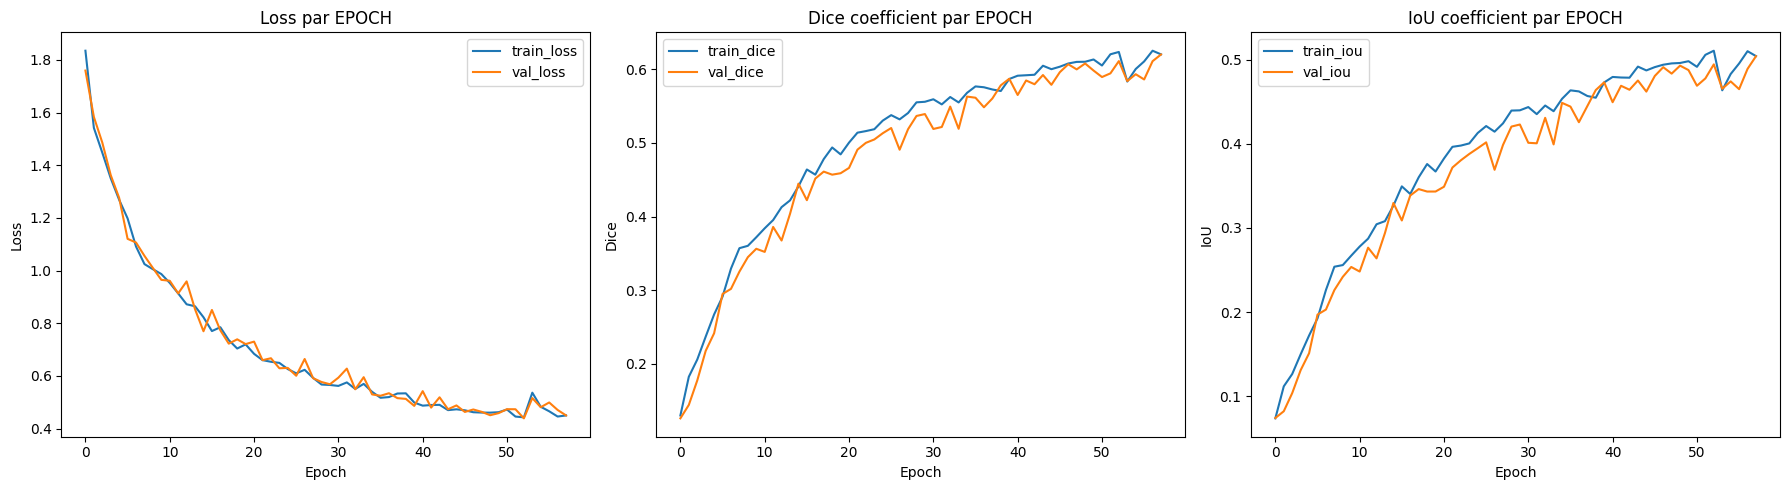

In [ ]:
#METRIQUES AVEC DATA AUGMENTATION


matplotlib.pyplot.figure(figsize=(18,5))

#Loss
matplotlib.pyplot.subplot(1,3,1)
matplotlib.pyplot.plot(history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(history.history["val_loss"], label="val_loss")
matplotlib.pyplot.title("Loss par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.legend()

#Dice coefficient
matplotlib.pyplot.subplot(1,3,2)
matplotlib.pyplot.plot(history.history["coef_dice_multi"], label="train_dice")
matplotlib.pyplot.plot(history.history["val_coef_dice_multi"], label="val_dice")
matplotlib.pyplot.title("Dice coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Dice")
matplotlib.pyplot.legend()

#IoU
matplotlib.pyplot.subplot(1,3,3)
matplotlib.pyplot.plot(history.history["coef_io_u_multi"], label="train_iou")
matplotlib.pyplot.plot(history.history["val_coef_io_u_multi"], label="val_iou")
matplotlib.pyplot.title("IoU coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("IoU")
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

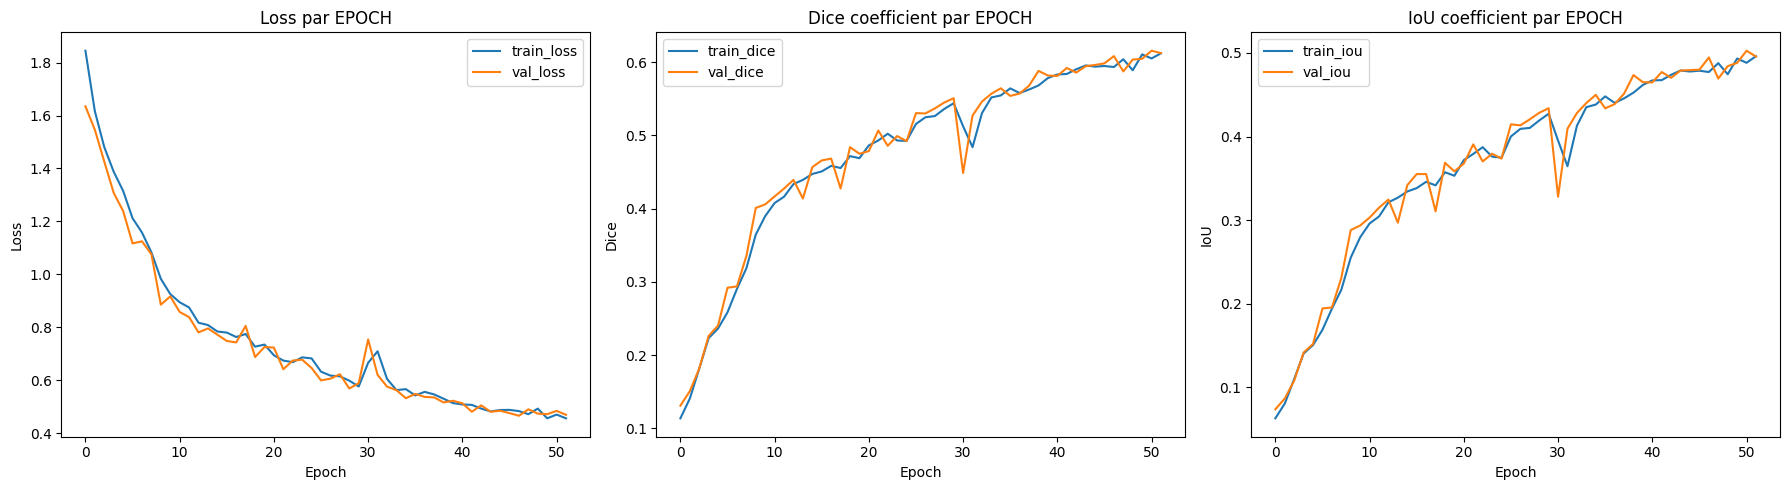

In [ ]:
#METRIQUES SANS DATA AUGMENTATION


matplotlib.pyplot.figure(figsize=(18,5))

#Loss
matplotlib.pyplot.subplot(1,3,1)
matplotlib.pyplot.plot(history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(history.history["val_loss"], label="val_loss")
matplotlib.pyplot.title("Loss par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.legend()

#Dice coefficient
matplotlib.pyplot.subplot(1,3,2)
matplotlib.pyplot.plot(history.history["coef_dice_multi"], label="train_dice")
matplotlib.pyplot.plot(history.history["val_coef_dice_multi"], label="val_dice")
matplotlib.pyplot.title("Dice coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Dice")
matplotlib.pyplot.legend()

#IoU
matplotlib.pyplot.subplot(1,3,3)
matplotlib.pyplot.plot(history.history["coef_io_u_multi"], label="train_iou")
matplotlib.pyplot.plot(history.history["val_coef_io_u_multi"], label="val_iou")
matplotlib.pyplot.title("IoU coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("IoU")
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 4.2.3 : Test du modèle avec Data-Augmentation

In [ ]:
#Chemin vers le modèle entraîné (avec Data-Augmentation)
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini.keras"

#Etape 1 : rechargement du modèle avec ses métriques personnalisées
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Etape 2 : récupération du nombre de batches
nbBatchesDeTest = len(generateurTest)

#Etape 3 : faire les prédictions batch par batch avec un index (plutôt que sur tout le dataset d'un coup, ce qui provoque un OOM sur le GPU)
resultatsDice = []
resultatsIoU = []
for i in range(nbBatchesDeTest):
    batch_X, batch_y = generateurTest[i] #Récupération du batch via index
    predictions = modelCharge.predict(batch_X, verbose=0)

    #Conversion en Tensors pour les métriques personnalisées
    y_true_batch = tensorflow.convert_to_tensor(batch_y, dtype=tensorflow.float32)
    y_pred_batch = tensorflow.convert_to_tensor(predictions, dtype=tensorflow.float32)

    #Calcul Dice & IoU
    dice_batch = coefDiceMulti(y_true_batch, y_pred_batch).numpy()
    iou_batch = coefIoUMulti(y_true_batch, y_pred_batch).numpy()
    resultatsDice.append(dice_batch)
    resultatsIoU.append(iou_batch)

#Etape 4 : moyenne sur tous les batches
resultatDice = numpy.mean(resultatsDice)
resultatIoU = numpy.mean(resultatsIoU)

#Affichage
print("\nDice coefficient :", resultatDice,
      "\nInterprétation   :",
      "\n\tDice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée"
      )
print("\n\nIoU            :", resultatIoU,
      "\nInterprétation :",
      "\n\tIoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes",
      "\n\tIoU = 0,7..0,8 et + : excellente segmentation",
      "\n\tIoU = 0,5..0,6      : segmentation correcte",
      "\n\tIoU = <0,3          : segmentation pas terrible...",
      "\n\tIoU = 0             : aucune intersection (prédictions totalement fausses)"
      )


Dice coefficient : 0.6148318 
Interprétation   : 
	Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée


IoU            : 0.49875888 
Interprétation : 
	IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes 
	IoU = 0,7..0,8 et + : excellente segmentation 
	IoU = 0,5..0,6      : segmentation correcte 
	IoU = <0,3          : segmentation pas terrible... 
	IoU = 0             : aucune intersection (prédictions totalement fausses)


#### 4.2.3.1 : Image/Masque/Prédiction (avec data-augmentation)

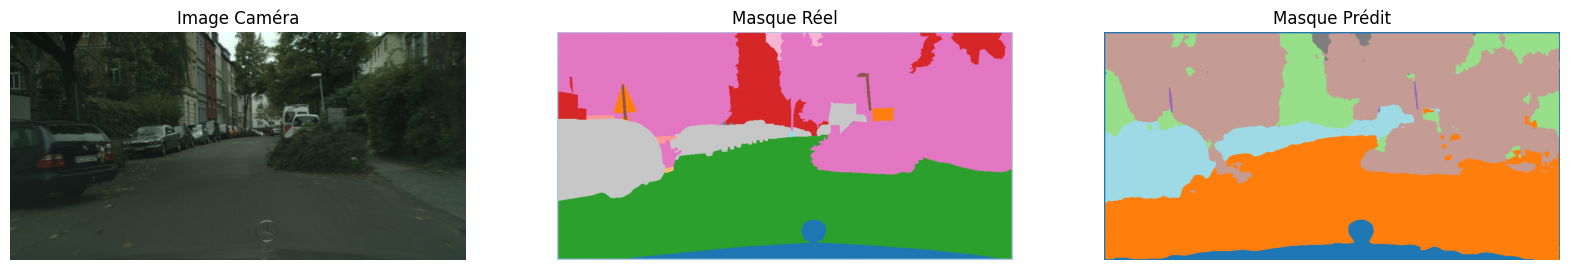

In [ ]:
#Numéro de l'image à afficher (le dataset de "test" contient 1023 triplets (image/colorMaps/Masques), donc choisir un chiffre entre 1 et 1023)
repertoireDonneesDeTest = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_dataset/test/"
numeroImageTest = 13

#Récupération de la liste des fichiers
fichiersCamera = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_leftImg8bit.png")])
fichiersMasquesReels = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_gtFine_labelIds.png")])
fichierCameraSelectionne = os.path.join(repertoireDonneesDeTest, fichiersCamera[numeroImageTest-1])
fichierMasqueSelectionne = os.path.join(repertoireDonneesDeTest, fichiersMasquesReels[numeroImageTest-1])

#Chargement de l'image caméra (+resize)
imageCamera = Image.open(fichierCameraSelectionne)
imageCamera_resized = imageCamera.resize((1024, 512))
imageCamera_array = numpy.array(imageCamera_resized)

#Chargement du masque réel (+resize)
imageMasque = Image.open(fichierMasqueSelectionne)
imageMasque_resized = imageMasque.resize((1024, 512), resample=Image.NEAREST)
imageMasque_array = numpy.array(imageMasque_resized)

#Préparation pour la prédiction
image_input = imageCamera_array.astype("float32") / 255
image_input = numpy.expand_dims(image_input, axis=0)  #= (1, 512, 1024, 3) - Histoire d'être raccord avec le prototypage d'entrée du modèle !

#Prédiction
prediction = modelCharge.predict(image_input, verbose=0)
masque_predit_array = numpy.argmax(prediction[0], axis=-1)

#Affichage : Caméra / Masque réel / Masque prédit
matplotlib.pyplot.figure(figsize=(20, 6))

#Caméra
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.title("Image Caméra")
matplotlib.pyplot.imshow(imageCamera_array)
matplotlib.pyplot.axis("off")

#Masque réel
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.title("Masque Réel")
matplotlib.pyplot.imshow(imageMasque_array, cmap="tab20")  #Utilisation d'une colormap pour les classes
matplotlib.pyplot.axis("off")

#Masque prédit
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.title("Masque Prédit")
matplotlib.pyplot.imshow(masque_predit_array, cmap="tab20")
matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()

### 4.2.4 : Test du modèle sans Data-Augmentation

In [ ]:
#Chemin vers le modèle entraîné (sans Data-Augmentation)
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_UnetMini_sans_DataAugmentation.keras"

#Etape 1 : rechargement du modèle avec ses métriques personnalisées
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Etape 2 : récupération du nombre de batches
nbBatchesDeTest = len(generateurTest)

#Etape 3 : faire les prédictions batch par batch avec un index (plutôt que sur tout le dataset d'un coup, ce qui provoque un OOM sur le GPU)
resultatsDice = []
resultatsIoU = []
for i in range(nbBatchesDeTest):
    batch_X, batch_y = generateurTest[i] #Récupération du batch via index
    predictions = modelCharge.predict(batch_X, verbose=0)

    #Conversion en Tensors pour les métriques personnalisées
    y_true_batch = tensorflow.convert_to_tensor(batch_y, dtype=tensorflow.float32)
    y_pred_batch = tensorflow.convert_to_tensor(predictions, dtype=tensorflow.float32)

    #Calcul Dice & IoU
    dice_batch = coefDiceMulti(y_true_batch, y_pred_batch).numpy()
    iou_batch = coefIoUMulti(y_true_batch, y_pred_batch).numpy()
    resultatsDice.append(dice_batch)
    resultatsIoU.append(iou_batch)

#Etape 4 : moyenne sur tous les batches
resultatDice = numpy.mean(resultatsDice)
resultatIoU = numpy.mean(resultatsIoU)

#Affichage
print("\nDice coefficient :", resultatDice,
      "\nInterprétation   :",
      "\n\tDice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée"
      )
print("\n\nIoU            :", resultatIoU,
      "\nInterprétation :",
      "\n\tIoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes",
      "\n\tIoU = 0,7..0,8 et + : excellente segmentation",
      "\n\tIoU = 0,5..0,6      : segmentation correcte",
      "\n\tIoU = <0,3          : segmentation pas terrible...",
      "\n\tIoU = 0             : aucune intersection (prédictions totalement fausses)"
      )


Dice coefficient : 0.612744 
Interprétation   : 
	Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée


IoU            : 0.50048023 
Interprétation : 
	IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes 
	IoU = 0,7..0,8 et + : excellente segmentation 
	IoU = 0,5..0,6      : segmentation correcte 
	IoU = <0,3          : segmentation pas terrible... 
	IoU = 0             : aucune intersection (prédictions totalement fausses)


#### 4.2.4.1 : Image/Masque/Prédiction (sans data-augmentation)

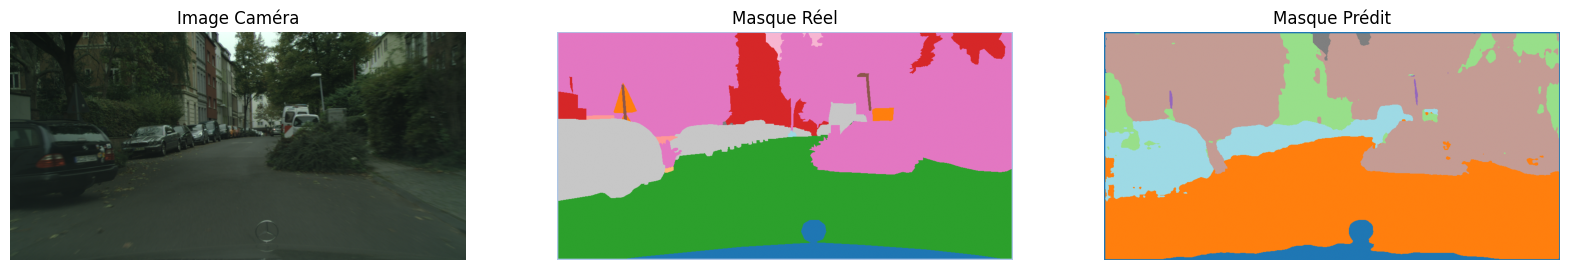

In [ ]:
#Numéro de l'image à afficher (le dataset de "test" contient 1023 triplets (image/colorMaps/Masques), donc choisir un chiffre entre 1 et 1023)
repertoireDonneesDeTest = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_dataset/test/"
numeroImageTest = 13

#Récupération de la liste des fichiers
fichiersCamera = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_leftImg8bit.png")])
fichiersMasquesReels = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_gtFine_labelIds.png")])
fichierCameraSelectionne = os.path.join(repertoireDonneesDeTest, fichiersCamera[numeroImageTest-1])
fichierMasqueSelectionne = os.path.join(repertoireDonneesDeTest, fichiersMasquesReels[numeroImageTest-1])

#Chargement de l'image caméra (+resize)
imageCamera = Image.open(fichierCameraSelectionne)
imageCamera_resized = imageCamera.resize((1024, 512))
imageCamera_array = numpy.array(imageCamera_resized)

#Chargement du masque réel (+resize)
imageMasque = Image.open(fichierMasqueSelectionne)
imageMasque_resized = imageMasque.resize((1024, 512), resample=Image.NEAREST)
imageMasque_array = numpy.array(imageMasque_resized)

#Préparation pour la prédiction
image_input = imageCamera_array.astype("float32") / 255
image_input = numpy.expand_dims(image_input, axis=0)  #= (1, 512, 1024, 3) - Histoire d'être raccord avec le prototypage d'entrée du modèle !

#Prédiction
prediction = modelCharge.predict(image_input, verbose=0)
masque_predit_array = numpy.argmax(prediction[0], axis=-1)

#Affichage : Caméra / Masque réel / Masque prédit
matplotlib.pyplot.figure(figsize=(20, 6))

#Caméra
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.title("Image Caméra")
matplotlib.pyplot.imshow(imageCamera_array)
matplotlib.pyplot.axis("off")

#Masque réel
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.title("Masque Réel")
matplotlib.pyplot.imshow(imageMasque_array, cmap="tab20")  #Utilisation d'une colormap pour les classes
matplotlib.pyplot.axis("off")

#Masque prédit
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.title("Masque Prédit")
matplotlib.pyplot.imshow(masque_predit_array, cmap="tab20")
matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()

## 4.3 : modèle (VGG16 + Unet)

In [7]:
#Imports Partie 4.3
import tensorflow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend

In [9]:
#Création du modèle VGG16+Unet


#Fonctions métriques
#Calcul du "Dice coefficient" (également appelé F1 score pour la segmentation) :
# Mesure la similarité entre deux ensembles (prédiction vs. réel), en mettant l’accent sur leur chevauchement.
# Utile en cas de contexte de classes déséquilibrées, car il double le poids de l’intersection.
#
#Interprétation :
# Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée
def coefDiceMulti(y_true, y_pred, smooth=1): #Calcul du Dice coefficient MOYEN sur toutes les classes
    y_true_f = tensorflow.keras.backend.reshape(y_true, (-1, 8)) #On transforme les tensors du masque réel (et ses 8 classes) en liste
    y_pred_f = tensorflow.keras.backend.reshape(y_pred, (-1, 8)) #On transforme les tensors du masque prédit (et ses 8 classes) en liste
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f, axis=0)
    sum_true_pred = tensorflow.keras.backend.sum(y_true_f, axis=0) + tensorflow.keras.backend.sum(y_pred_f, axis=0)
    dice_per_class = (2 * intersection + smooth) / (sum_true_pred + smooth)
    return tensorflow.keras.backend.mean(dice_per_class)

#Calcul de l'"Intersection Over Union coefficient" (IoU) :
# Evalue la qualité d’une prédiction en calculant le ratio entre l’intersection et l’union des ensembles prédits et réels.
# Pénalise plus fortement les erreurs de classification que le Dice.
#
#Interprétation :
# IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes
# IoU = 0,7..0,8 et + : excellente segmentation
# IoU = 0,5..0,6      : segmentation correcte
# IoU = <0,3          : segmentation pas terrible...
# IoU = 0             : aucune intersection (prédictions totalement fausses)
def coefIoUMulti(y_true, y_pred, smooth=1): #Calcul de l'IoU moyen sur toutes les classes
    y_true_f = tensorflow.keras.backend.reshape(y_true, (-1, 8))
    y_pred_f = tensorflow.keras.backend.reshape(y_pred, (-1, 8))
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f, axis=0)
    union = tensorflow.keras.backend.sum(y_true_f, axis=0) + tensorflow.keras.backend.sum(y_pred_f, axis=0) - intersection
    iou_per_class = (intersection + smooth) / (union + smooth)
    return tensorflow.keras.backend.mean(iou_per_class)


#Fonctions LOSS
def diceLoss(y_true, y_pred): #Loss Dice
    return 1 - coefDiceMulti(y_true, y_pred)

def balancedCrossEntropy(y_true, y_pred): #Loss CrossEntropy
    bce = tensorflow.keras.losses.CategoricalCrossentropy()
    return bce(y_true, y_pred)

def totalLoss(y_true, y_pred): #Loss combinée : Dice + Crossentropy
    return diceLoss(y_true, y_pred) + balancedCrossEntropy(y_true, y_pred)


#Définition des couches du modèle VGG16+Unet
def creationModeleVGG16Unet(tailleImage=(224, 224, 3)):
    #######################
    #Encodeur pré-entraîné# : compresse les données d’entrée en une représentation plus compacte
    #######################
    inputs = Input(tailleImage)
    backbone = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    #On récupère certaines couches pour les connections skip (comme dans UNet)
    c1 = backbone.get_layer("block1_conv2").output  # 224x224
    c2 = backbone.get_layer("block2_conv2").output  # 112x112
    c3 = backbone.get_layer("block3_conv3").output  # 56x56
    c4 = backbone.get_layer("block4_conv3").output  # 28x28
    c5 = backbone.get_layer("block5_conv3").output  # 14x14 (bottleneck) --> beaucoup d’info globale, mais peu de détails fins ; C'est la couche la plus profonde du réseau de neurones

    #On gèle les couches du backbone pour profiter du transfer learning
    for layer in backbone.layers:
        layer.trainable = False

    ##########
    #Décodeur# : reconstruit les données originales à partir de la représentation compacte issue de la couche de Bottleneck
    ##########
    u6 = UpSampling2D((2,2))(c5)                                    #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u6 = concatenate([u6, c4])                                      #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c6 = Conv2D(512, (3,3), activation="relu", padding="same")(u6)  #...
    c6 = Conv2D(512, (3,3), activation="relu", padding="same")(c6)  #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    u7 = UpSampling2D((2,2))(c6)                                    #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u7 = concatenate([u7, c3])                                      #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c7 = Conv2D(256, (3,3), activation="relu", padding="same")(u7)  #...
    c7 = Conv2D(256, (3,3), activation="relu", padding="same")(c7)  #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    u8 = UpSampling2D((2,2))(c7)                                    #Couche d'UPSAMPLING (but : augmenter la taille de l'image)
    u8 = concatenate([u8, c2])                                      #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c8 = Conv2D(128, (3,3), activation="relu", padding="same")(u8)  #...
    c8 = Conv2D(128, (3,3), activation="relu", padding="same")(c8)  #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    u9 = UpSampling2D((2,2))(c8)                                    #Couche d'UPSAMPLING (but : augmenter la taille de l'image) / Retour en 224x224 pixels !
    u9 = concatenate([u9, c1])                                      #Couche de CONCATENATION du décodeur (but : fusionner les infos de l’encodeur avec l’upsampling du décodeur)
    c9 = Conv2D(64, (3,3), activation="relu", padding="same")(u9)   #...
    c9 = Conv2D(64, (3,3), activation="relu", padding="same")(c9)   #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    c10 = Conv2D(32, (3,3), activation="relu", padding="same")(c9)  #...
    c10 = Conv2D(32, (3,3), activation="relu", padding="same")(c10) #2 couches de CONVOLUTION pour le décodeur (but : trouver/reconnaître des patterns dans l'image)

    outputs = Conv2D(8, (1,1), activation="softmax")(c10)           #Dernière couche (but : couche de prédiction multi-classes pour les 8 catégories)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

#Instanciation du modèle
model_VGG16Unet = creationModeleVGG16Unet(tailleImage=(224,224,3))

#Choix de la LOSS, entre : diceLoss, balancedCrossEntropy ou totalLoss #J'essaierai d'en tester plusieurs si l'entraînement ne dure pas trop longtemps...
choixDeLaLoss = balancedCrossEntropy

#Compilation : optimiseur Adam + loss choisie + métriques personnalisée
model_VGG16Unet.compile(optimizer="adam", loss=choixDeLaLoss, metrics=["accuracy", coefDiceMulti, coefIoUMulti])
model_VGG16Unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,919,048 (95.06 MB)

 Trainable params: 10,204,360 (38.93 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 4.3.1 : entraînement (VGG16 + Unet) - Avec/Sans Data-Augmentation

In [ ]:
#Imports Partie 4.3.1
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
#ENTRAÎNEMENT

#Etape 1 : définition du chemin de sauvegarde du meilleur modèle
#cheminMeilleurModel = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet.keras"
cheminMeilleurModel = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras"

#Etape 2: Callbacks / EarlyStopping
checkPointModel = ModelCheckpoint(filepath=cheminMeilleurModel, monitor="val_loss", save_best_only=True, mode="min", verbose=1)
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1, restore_best_weights=True)
listCallbacks = [checkPointModel, earlyStopping]

#Etape 3 : entraînement du modèle
nbEpochs = 100

mlflow.set_experiment("Image_Segmentation")
mlflow.tensorflow.autolog()
#with mlflow.start_run(run_name="VGG16Unet"):
with mlflow.start_run(run_name="VGG16Unet_sans_DataAugmentation"):
#    mlflow.log_param("preprocessing_type", "Resize images 50% + Data-augmentation (Albumentations)")
    mlflow.log_param("preprocessing_type", "Resize images 50%")
#    mlflow.set_tag("model_type", "VGG16Unet")
    mlflow.set_tag("model_type", "VGG16Unet_sans_DataAugmentation")
    history = model_VGG16Unet.fit(generateurTrain, validation_data=generateurVal, epochs=nbEpochs, callbacks=listCallbacks, verbose=1)

    #Sauvegarde du MEILLEUR modèle dans MLflow
    print("Sauvegarde du modèle dans MLflow...")
#    mlflow.log_artifact(cheminMeilleurModel, artifact_path="VGG16Unet")
    mlflow.log_artifact(cheminMeilleurModel, artifact_path="VGG16Unet_sans_DataAugmentation")

mlflow.end_run()

2025/09/30 14:14:42 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.SegmentationDataGenerator'>. Dataset logging skipped.
2025/09/30 14:14:42 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.SegmentationDataGenerator'>. Dataset logging skipped.


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2609 - coef_dice_multi: 0.0939 - coef_io_u_multi: 0.0532 - loss: 3.7006
Epoch 1: val_loss improved from inf to 1.38125, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 271s 8s/step - accuracy: 0.2643 - coef_dice_multi: 0.0949 - coef_io_u_multi: 0.0538 - loss: 3.6598 - val_accuracy: 0.5573 - val_coef_dice_multi: 0.1921 - val_coef_io_u_multi: 0.1233 - val_loss: 1.3813
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5692 - coef_dice_multi: 0.2193 - coef_io_u_multi: 0.1455 - loss: 1.2757
Epoch 2: val_loss improved from 1.38125 to 1.06654, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 256s 8s/step - accuracy: 0.5697 - coef_dice_multi: 0.2198 - coef_io_u_multi: 0.1459 - loss: 1.2736 - val_accuracy: 0.6169 - val_coef_dice_multi: 0.2561 - val_coef_io_u_multi: 0.1759 - val_loss: 1.0665
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6272 - coef_dice_multi: 0.2762 - coef_io_u_multi: 0.1928 - loss: 1.0243
Epoch 3: val_loss improved from 1.06654 to 0.91134, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.6278 - coef_dice_multi: 0.2767 - coef_io_u_multi: 0.1932 - loss: 1.0231 - val_accuracy: 0.6987 - val_coef_dice_multi: 0.3284 - val_coef_io_u_multi: 0.2345 - val_loss: 0.9113
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7046 - coef_dice_multi: 0.3452 - coef_io_u_multi: 0.2445 - loss: 0.8706
Epoch 4: val_loss improved from 0.91134 to 0.75688, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.7050 - coef_dice_multi: 0.3458 - coef_io_u_multi: 0.2449 - loss: 0.8697 - val_accuracy: 0.7590 - val_coef_dice_multi: 0.4200 - val_coef_io_u_multi: 0.3049 - val_loss: 0.7569
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7675 - coef_dice_multi: 0.4369 - coef_io_u_multi: 0.3209 - loss: 0.7279
Epoch 5: val_loss improved from 0.75688 to 0.67462, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.7675 - coef_dice_multi: 0.4371 - coef_io_u_multi: 0.3210 - loss: 0.7281 - val_accuracy: 0.7887 - val_coef_dice_multi: 0.4583 - val_coef_io_u_multi: 0.3412 - val_loss: 0.6746
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7841 - coef_dice_multi: 0.4633 - coef_io_u_multi: 0.3449 - loss: 0.6879
Epoch 6: val_loss improved from 0.67462 to 0.59508, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.7845 - coef_dice_multi: 0.4640 - coef_io_u_multi: 0.3455 - loss: 0.6868 - val_accuracy: 0.8169 - val_coef_dice_multi: 0.5123 - val_coef_io_u_multi: 0.3941 - val_loss: 0.5951
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8122 - coef_dice_multi: 0.5126 - coef_io_u_multi: 0.3939 - loss: 0.6054
Epoch 7: val_loss did not improve from 0.59508
33/33 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.8122 - coef_dice_multi: 0.5126 - coef_io_u_multi: 0.3939 - loss: 0.6055 - val_accuracy: 0.8196 - val_coef_dice_multi: 0.5263 - val_coef_io_u_multi: 0.4080 - val_loss: 0.5980
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8271 - coef_dice_multi: 0.5393 - coef_io_u_multi: 0.4228 - loss: 0.5610
Epoch 8: val_loss improved from 0.59508 to 0.56955, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.8270 - coef_dice_multi: 0.5391 - coef_io_u_multi: 0.4226 - loss: 0.5614 - val_accuracy: 0.8279 - val_coef_dice_multi: 0.5259 - val_coef_io_u_multi: 0.4038 - val_loss: 0.5695
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8284 - coef_dice_multi: 0.5433 - coef_io_u_multi: 0.4256 - loss: 0.5575
Epoch 9: val_loss improved from 0.56955 to 0.56359, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.8284 - coef_dice_multi: 0.5434 - coef_io_u_multi: 0.4257 - loss: 0.5574 - val_accuracy: 0.8286 - val_coef_dice_multi: 0.5170 - val_coef_io_u_multi: 0.3948 - val_loss: 0.5636
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8341 - coef_dice_multi: 0.5468 - coef_io_u_multi: 0.4301 - loss: 0.5484
Epoch 10: val_loss improved from 0.56359 to 0.50072, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 258s 8s/step - accuracy: 0.8342 - coef_dice_multi: 0.5470 - coef_io_u_multi: 0.4304 - loss: 0.5480 - val_accuracy: 0.8474 - val_coef_dice_multi: 0.5767 - val_coef_io_u_multi: 0.4629 - val_loss: 0.5007
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8397 - coef_dice_multi: 0.5644 - coef_io_u_multi: 0.4481 - loss: 0.5238
Epoch 11: val_loss did not improve from 0.50072
33/33 ━━━━━━━━━━━━━━━━━━━━ 256s 8s/step - accuracy: 0.8398 - coef_dice_multi: 0.5646 - coef_io_u_multi: 0.4484 - loss: 0.5234 - val_accuracy: 0.8510 - val_coef_dice_multi: 0.5917 - val_coef_io_u_multi: 0.4822 - val_loss: 0.5063
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8390 - coef_dice_multi: 0.5761 - coef_io_u_multi: 0.4608 - loss: 0.5247
Epoch 12: val_loss improved from 0.50072 to 0.49554, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.8391 - coef_dice_multi: 0.5760 - coef_io_u_multi: 0.4607 - loss: 0.5243 - val_accuracy: 0.8501 - val_coef_dice_multi: 0.5723 - val_coef_io_u_multi: 0.4581 - val_loss: 0.4955
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8514 - coef_dice_multi: 0.5816 - coef_io_u_multi: 0.4700 - loss: 0.4831
Epoch 13: val_loss did not improve from 0.49554
33/33 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.8514 - coef_dice_multi: 0.5817 - coef_io_u_multi: 0.4701 - loss: 0.4833 - val_accuracy: 0.8495 - val_coef_dice_multi: 0.5806 - val_coef_io_u_multi: 0.4656 - val_loss: 0.4973
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8556 - coef_dice_multi: 0.5919 - coef_io_u_multi: 0.4801 - loss: 0.4679
Epoch 14: val_loss improved from 0.49554 to 0.46512, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.8555 - coef_dice_multi: 0.5918 - coef_io_u_multi: 0.4800 - loss: 0.4682 - val_accuracy: 0.8575 - val_coef_dice_multi: 0.5973 - val_coef_io_u_multi: 0.4838 - val_loss: 0.4651
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8598 - coef_dice_multi: 0.5994 - coef_io_u_multi: 0.4887 - loss: 0.4548
Epoch 15: val_loss improved from 0.46512 to 0.43849, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.8598 - coef_dice_multi: 0.5995 - coef_io_u_multi: 0.4887 - loss: 0.4549 - val_accuracy: 0.8667 - val_coef_dice_multi: 0.6089 - val_coef_io_u_multi: 0.4995 - val_loss: 0.4385
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8573 - coef_dice_multi: 0.6030 - coef_io_u_multi: 0.4924 - loss: 0.4637
Epoch 16: val_loss did not improve from 0.43849
33/33 ━━━━━━━━━━━━━━━━━━━━ 258s 8s/step - accuracy: 0.8573 - coef_dice_multi: 0.6030 - coef_io_u_multi: 0.4924 - loss: 0.4636 - val_accuracy: 0.8633 - val_coef_dice_multi: 0.6092 - val_coef_io_u_multi: 0.4998 - val_loss: 0.4428
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8643 - coef_dice_multi: 0.6118 - coef_io_u_multi: 0.5031 - loss: 0.4344
Epoch 17: val_loss did not improve from 0.43849
33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8643 - coef_dice_multi: 0.6119 - coef_io_u_multi: 0.5031 - loss: 0.4344 - val_accuracy: 0.8670 - val_coef_dice_multi: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.8624 - coef_dice_multi: 0.6161 - coef_io_u_multi: 0.5048 - loss: 0.4463 - val_accuracy: 0.8698 - val_coef_dice_multi: 0.6203 - val_coef_io_u_multi: 0.5082 - val_loss: 0.4299
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8641 - coef_dice_multi: 0.6134 - coef_io_u_multi: 0.5024 - loss: 0.4352
Epoch 19: val_loss improved from 0.42988 to 0.42896, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.8642 - coef_dice_multi: 0.6136 - coef_io_u_multi: 0.5026 - loss: 0.4348 - val_accuracy: 0.8696 - val_coef_dice_multi: 0.6316 - val_coef_io_u_multi: 0.5198 - val_loss: 0.4290
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8673 - coef_dice_multi: 0.6266 - coef_io_u_multi: 0.5155 - loss: 0.4242
Epoch 20: val_loss did not improve from 0.42896
33/33 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.8673 - coef_dice_multi: 0.6265 - coef_io_u_multi: 0.5154 - loss: 0.4244 - val_accuracy: 0.8654 - val_coef_dice_multi: 0.6182 - val_coef_io_u_multi: 0.5111 - val_loss: 0.4395
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8657 - coef_dice_multi: 0.6212 - coef_io_u_multi: 0.5098 - loss: 0.4301
Epoch 21: val_loss improved from 0.42896 to 0.42113, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.8658 - coef_dice_multi: 0.6214 - coef_io_u_multi: 0.5100 - loss: 0.4298 - val_accuracy: 0.8684 - val_coef_dice_multi: 0.6235 - val_coef_io_u_multi: 0.5141 - val_loss: 0.4211
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8719 - coef_dice_multi: 0.6383 - coef_io_u_multi: 0.5283 - loss: 0.4044
Epoch 22: val_loss did not improve from 0.42113
33/33 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.8719 - coef_dice_multi: 0.6382 - coef_io_u_multi: 0.5282 - loss: 0.4044 - val_accuracy: 0.8674 - val_coef_dice_multi: 0.6232 - val_coef_io_u_multi: 0.5130 - val_loss: 0.4288
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8665 - coef_dice_multi: 0.6234 - coef_io_u_multi: 0.5133 - loss: 0.4251
Epoch 23: val_loss did not improve from 0.42113
33/33 ━━━━━━━━━━━━━━━━━━━━ 246s 7s/step - accuracy: 0.8666 - coef_dice_multi: 0.6236 - coef_io_u_multi: 0.5134 - loss: 0.4250 - val_accuracy: 0.8616 - val_coef_dice_multi: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 247s 8s/step - accuracy: 0.8650 - coef_dice_multi: 0.6263 - coef_io_u_multi: 0.5140 - loss: 0.4300 - val_accuracy: 0.8764 - val_coef_dice_multi: 0.6471 - val_coef_io_u_multi: 0.5395 - val_loss: 0.4047
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8740 - coef_dice_multi: 0.6447 - coef_io_u_multi: 0.5355 - loss: 0.3988
Epoch 25: val_loss improved from 0.40475 to 0.40350, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.8741 - coef_dice_multi: 0.6447 - coef_io_u_multi: 0.5355 - loss: 0.3986 - val_accuracy: 0.8758 - val_coef_dice_multi: 0.6359 - val_coef_io_u_multi: 0.5259 - val_loss: 0.4035
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8763 - coef_dice_multi: 0.6398 - coef_io_u_multi: 0.5312 - loss: 0.3905
Epoch 26: val_loss did not improve from 0.40350
33/33 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.8763 - coef_dice_multi: 0.6399 - coef_io_u_multi: 0.5313 - loss: 0.3906 - val_accuracy: 0.8696 - val_coef_dice_multi: 0.6410 - val_coef_io_u_multi: 0.5305 - val_loss: 0.4242
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8718 - coef_dice_multi: 0.6382 - coef_io_u_multi: 0.5266 - loss: 0.4104
Epoch 27: val_loss improved from 0.40350 to 0.39831, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.8719 - coef_dice_multi: 0.6384 - coef_io_u_multi: 0.5268 - loss: 0.4100 - val_accuracy: 0.8795 - val_coef_dice_multi: 0.6551 - val_coef_io_u_multi: 0.5464 - val_loss: 0.3983
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8842 - coef_dice_multi: 0.6541 - coef_io_u_multi: 0.5465 - loss: 0.3686
Epoch 28: val_loss improved from 0.39831 to 0.38887, saving model to /content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.8841 - coef_dice_multi: 0.6540 - coef_io_u_multi: 0.5464 - loss: 0.3689 - val_accuracy: 0.8807 - val_coef_dice_multi: 0.6508 - val_coef_io_u_multi: 0.5421 - val_loss: 0.3889
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8808 - coef_dice_multi: 0.6577 - coef_io_u_multi: 0.5475 - loss: 0.3808
Epoch 29: val_loss did not improve from 0.38887
33/33 ━━━━━━━━━━━━━━━━━━━━ 256s 8s/step - accuracy: 0.8808 - coef_dice_multi: 0.6576 - coef_io_u_multi: 0.5474 - loss: 0.3807 - val_accuracy: 0.8782 - val_coef_dice_multi: 0.6449 - val_coef_io_u_multi: 0.5382 - val_loss: 0.3941
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8841 - coef_dice_multi: 0.6588 - coef_io_u_multi: 0.5511 - loss: 0.3679
Epoch 30: val_loss did not improve from 0.38887
33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8840 - coef_dice_multi: 0.6587 - coef_io_u_multi: 0.5509 - loss: 0.3683 - val_accuracy: 0.8799 - val_coef_dice_multi: 0.

2025/09/30 16:34:52 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2025/09/30 16:34:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:34:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/30 16:35:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpe3_m_5ja/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/09/30 16:35:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging

Sauvegarde du modèle dans MLflow...


### 4.3.2 : métriques - Avec/Sans Data-Augmentation

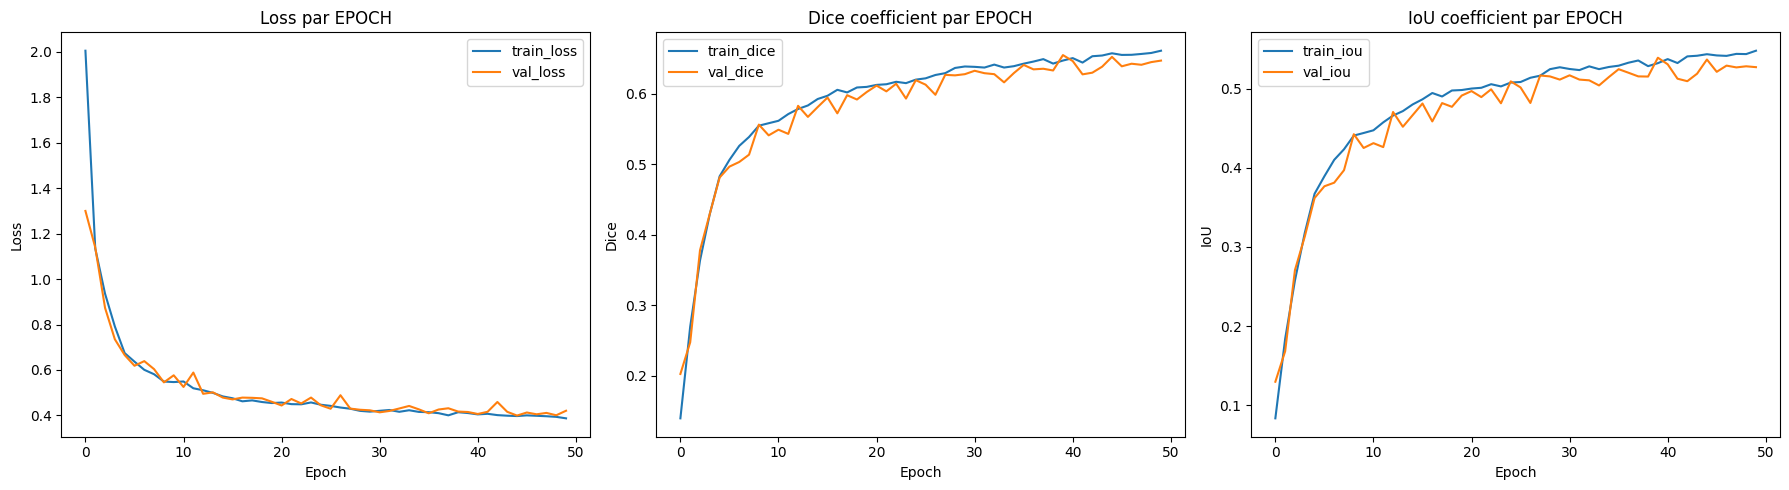

In [ ]:
#METRIQUES AVEC DATA AUGMENTATION


matplotlib.pyplot.figure(figsize=(18,5))

#Loss
matplotlib.pyplot.subplot(1,3,1)
matplotlib.pyplot.plot(history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(history.history["val_loss"], label="val_loss")
matplotlib.pyplot.title("Loss par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.legend()

#Dice coefficient
matplotlib.pyplot.subplot(1,3,2)
matplotlib.pyplot.plot(history.history["coef_dice_multi"], label="train_dice")
matplotlib.pyplot.plot(history.history["val_coef_dice_multi"], label="val_dice")
matplotlib.pyplot.title("Dice coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Dice")
matplotlib.pyplot.legend()

#IoU
matplotlib.pyplot.subplot(1,3,3)
matplotlib.pyplot.plot(history.history["coef_io_u_multi"], label="train_iou")
matplotlib.pyplot.plot(history.history["val_coef_io_u_multi"], label="val_iou")
matplotlib.pyplot.title("IoU coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("IoU")
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

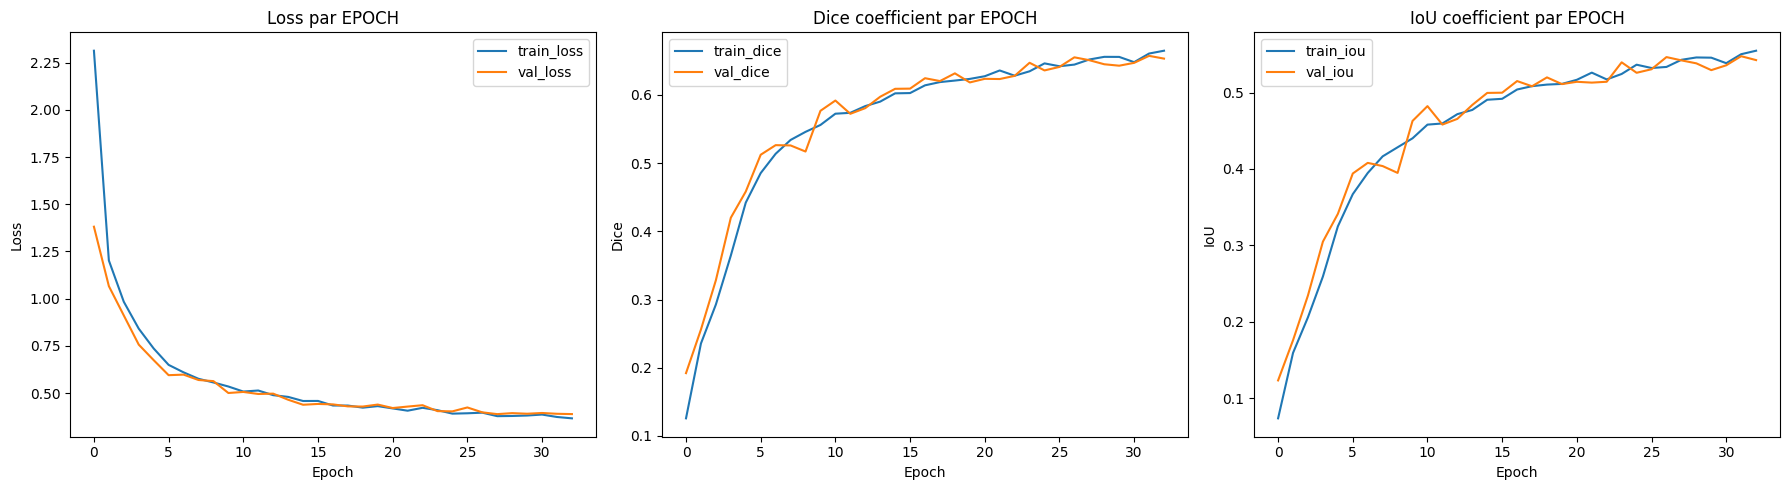

In [ ]:
#METRIQUES SANS DATA AUGMENTATION


matplotlib.pyplot.figure(figsize=(18,5))

#Loss
matplotlib.pyplot.subplot(1,3,1)
matplotlib.pyplot.plot(history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(history.history["val_loss"], label="val_loss")
matplotlib.pyplot.title("Loss par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.legend()

#Dice coefficient
matplotlib.pyplot.subplot(1,3,2)
matplotlib.pyplot.plot(history.history["coef_dice_multi"], label="train_dice")
matplotlib.pyplot.plot(history.history["val_coef_dice_multi"], label="val_dice")
matplotlib.pyplot.title("Dice coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Dice")
matplotlib.pyplot.legend()

#IoU
matplotlib.pyplot.subplot(1,3,3)
matplotlib.pyplot.plot(history.history["coef_io_u_multi"], label="train_iou")
matplotlib.pyplot.plot(history.history["val_coef_io_u_multi"], label="val_iou")
matplotlib.pyplot.title("IoU coefficient par EPOCH")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("IoU")
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 4.3.3 : Test du modèle avec Data-Augmentation

In [10]:
#Chemin vers le modèle entraîné (avec Data-Augmentation)
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet.keras"

#Etape 1 : rechargement du modèle avec ses métriques personnalisées
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Etape 2 : récupération du nombre de batches
nbBatchesDeTest = len(generateurTest)

#Etape 3 : faire les prédictions batch par batch avec un index (plutôt que sur tout le dataset d'un coup, ce qui provoque un OOM sur le GPU)
resultatsDice = []
resultatsIoU = []
for i in range(nbBatchesDeTest):
    batch_X, batch_y = generateurTest[i] #Récupération du batch via index
    predictions = modelCharge.predict(batch_X, verbose=0)

    #Conversion en Tensors pour les métriques personnalisées
    y_true_batch = tensorflow.convert_to_tensor(batch_y, dtype=tensorflow.float32)
    y_pred_batch = tensorflow.convert_to_tensor(predictions, dtype=tensorflow.float32)

    #Calcul Dice & IoU
    dice_batch = coefDiceMulti(y_true_batch, y_pred_batch).numpy()
    iou_batch = coefIoUMulti(y_true_batch, y_pred_batch).numpy()
    resultatsDice.append(dice_batch)
    resultatsIoU.append(iou_batch)

#Etape 4 : moyenne sur tous les batches
resultatDice = numpy.mean(resultatsDice)
resultatIoU = numpy.mean(resultatsIoU)

#Affichage
print("\nDice coefficient :", resultatDice,
      "\nInterprétation   :",
      "\n\tDice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée"
      )
print("\n\nIoU            :", resultatIoU,
      "\nInterprétation :",
      "\n\tIoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes",
      "\n\tIoU = 0,7..0,8 et + : excellente segmentation",
      "\n\tIoU = 0,5..0,6      : segmentation correcte",
      "\n\tIoU = <0,3          : segmentation pas terrible...",
      "\n\tIoU = 0             : aucune intersection (prédictions totalement fausses)"
      )

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Dice coefficient : 0.6514939 
Interprétation   : 
	Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée


IoU            : 0.5365046 
Interprétation : 
	IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes 
	IoU = 0,7..0,8 et + : excellente segmentation 
	IoU = 0,5..0,6      : segmentation correcte 
	IoU = <0,3          : segmentation pas terrible... 
	IoU = 0             : aucune intersection (prédictions totalement fausses)


#### 4.3.3.1 : Image/Masque/Prédiction (avec data-augmentation)

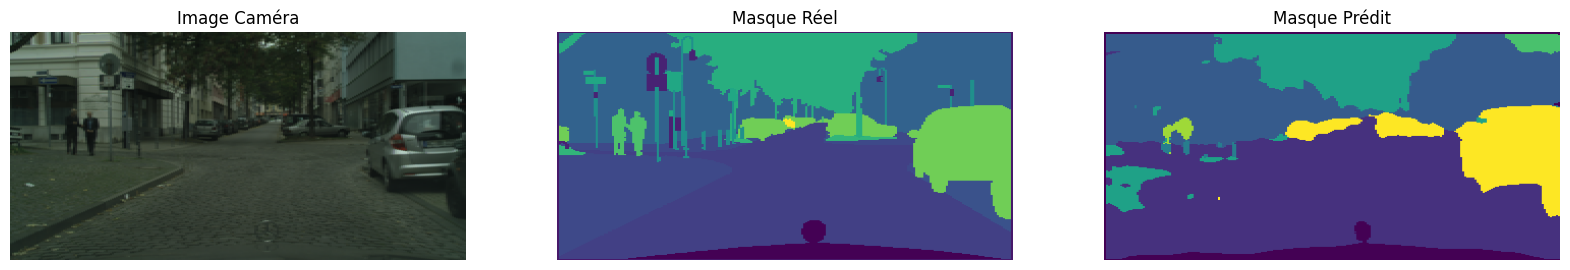

In [201]:
#Rechargement du modèle
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet.keras"
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Numéro de l'image à afficher (le dataset de "test" contient 1023 triplets (image/colorMaps/Masques), donc choisir un chiffre entre 1 et 1023)
repertoireDonneesDeTest = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_dataset/test/"
numeroImageTest = 7

#Récupération de la liste des fichiers
fichiersCamera = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_leftImg8bit.png")])
fichiersMasquesReels = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_gtFine_labelIds.png")])
fichierCameraSelectionne = os.path.join(repertoireDonneesDeTest, fichiersCamera[numeroImageTest-1])
fichierMasqueSelectionne = os.path.join(repertoireDonneesDeTest, fichiersMasquesReels[numeroImageTest-1])

#Chargement de l'image caméra (+resize)
imageCamera = Image.open(fichierCameraSelectionne)
imageCamera_resized = imageCamera.resize((224, 224))
imageCamera_array = numpy.array(imageCamera_resized)

#Chargement du masque réel (+resize)
imageMasque = Image.open(fichierMasqueSelectionne)
imageMasque_resized = imageMasque.resize((224, 224), resample=Image.NEAREST)
imageMasque_array = numpy.array(imageMasque_resized)

#Préparation pour la prédiction
image_input = imageCamera_array.astype("float32") / 255
image_input = numpy.expand_dims(image_input, axis=0)  #= (1, 224, 224, 3) - Histoire d'être raccord avec le prototypage d'entrée du modèle !

#Prédiction
prediction = modelCharge.predict(image_input, verbose=0)
masque_predit_array = numpy.argmax(prediction[0], axis=-1)

#Resize des images pour l'affichage
imageCamera_array = numpy.array(Image.fromarray(imageCamera_array.astype(numpy.uint8)).resize((imageCamera_array.shape[1] * 2, imageCamera_array.shape[0]), resample=Image.NEAREST))
imageMasque_array = numpy.array(Image.fromarray(imageMasque_array.astype(numpy.uint8)).resize((imageMasque_array.shape[1] * 2, imageMasque_array.shape[0]), resample=Image.NEAREST))
masque_predit_array = numpy.array(Image.fromarray(masque_predit_array.astype(numpy.uint8)).resize((masque_predit_array.shape[1] * 2, masque_predit_array.shape[0]), resample=Image.NEAREST))

#Affichage : Caméra / Masque réel / Masque prédit
matplotlib.pyplot.figure(figsize=(20, 6))

#Caméra
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.title("Image Caméra")
matplotlib.pyplot.imshow(imageCamera_array)
matplotlib.pyplot.axis("off")

#Masque réel
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.title("Masque Réel")
matplotlib.pyplot.imshow(imageMasque_array, cmap="viridis")  #Utilisation d'une colormap pour les classes
matplotlib.pyplot.axis("off")

#Masque prédit
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.title("Masque Prédit")
matplotlib.pyplot.imshow(masque_predit_array, cmap="viridis")
matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()

### 4.3.4 : Test du modèle sans Data-Augmentation

In [119]:
#Chemin vers le modèle entraîné (sans Data-Augmentation)
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras"

#Etape 1 : rechargement du modèle avec ses métriques personnalisées
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Etape 2 : récupération du nombre de batches
nbBatchesDeTest = len(generateurTest)

#Etape 3 : faire les prédictions batch par batch avec un index (plutôt que sur tout le dataset d'un coup, ce qui provoque un OOM sur le GPU)
resultatsDice = []
resultatsIoU = []
for i in range(nbBatchesDeTest):
    batch_X, batch_y = generateurTest[i] #Récupération du batch via index
    predictions = modelCharge.predict(batch_X, verbose=0)

    #Conversion en Tensors pour les métriques personnalisées
    y_true_batch = tensorflow.convert_to_tensor(batch_y, dtype=tensorflow.float32)
    y_pred_batch = tensorflow.convert_to_tensor(predictions, dtype=tensorflow.float32)

    #Calcul Dice & IoU
    dice_batch = coefDiceMulti(y_true_batch, y_pred_batch).numpy()
    iou_batch = coefIoUMulti(y_true_batch, y_pred_batch).numpy()
    resultatsDice.append(dice_batch)
    resultatsIoU.append(iou_batch)

#Etape 4 : moyenne sur tous les batches
resultatDice = numpy.mean(resultatsDice)
resultatIoU = numpy.mean(resultatsIoU)

#Affichage
print("\nDice coefficient :", resultatDice,
      "\nInterprétation   :",
      "\n\tDice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée"
      )
print("\n\nIoU            :", resultatIoU,
      "\nInterprétation :",
      "\n\tIoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes",
      "\n\tIoU = 0,7..0,8 et + : excellente segmentation",
      "\n\tIoU = 0,5..0,6      : segmentation correcte",
      "\n\tIoU = <0,3          : segmentation pas terrible...",
      "\n\tIoU = 0             : aucune intersection (prédictions totalement fausses)"
      )


Dice coefficient : 0.6496253 
Interprétation   : 
	Dice = 0,85 indique que le masque prédit et le masque réel ont un chevauchement représentant 85 % de leur taille combinée


IoU            : 0.541016 
Interprétation : 
	IoU = 1             : recouvrement parfait entre prédiction et vérité terrain pour toutes les classes 
	IoU = 0,7..0,8 et + : excellente segmentation 
	IoU = 0,5..0,6      : segmentation correcte 
	IoU = <0,3          : segmentation pas terrible... 
	IoU = 0             : aucune intersection (prédictions totalement fausses)


#### 4.3.4.1 : Image/Masque/Prédiction (sans data-augmentation)

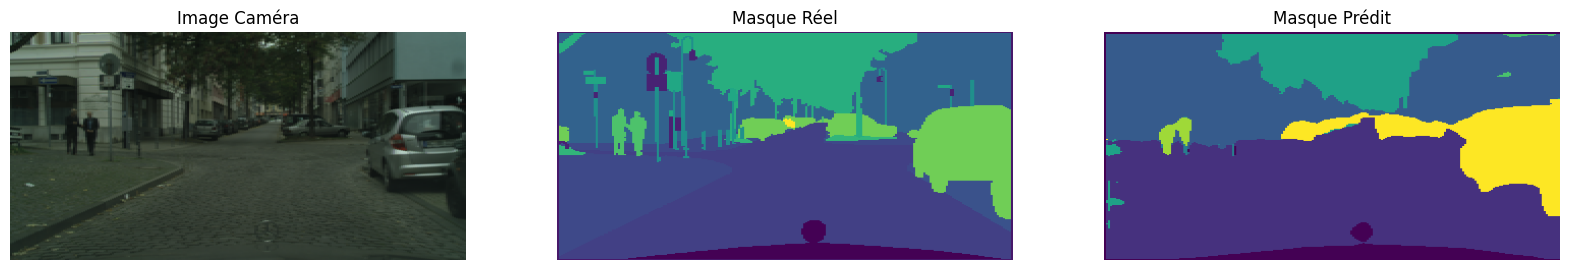

In [200]:
#Rechargement du modèle
cheminModele = "/content/drive/My Drive/Colab_Notebooks/Project_8/best_model_VGG16Unet_sans_DataAugmentation.keras"
modelCharge = tensorflow.keras.models.load_model(cheminModele, custom_objects={"coefDiceMulti": coefDiceMulti, "coefIoUMulti": coefIoUMulti, "balancedCrossEntropy": balancedCrossEntropy})

#Numéro de l'image à afficher (le dataset de "test" contient 1023 triplets (image/colorMaps/Masques), donc choisir un chiffre entre 1 et 1023)
repertoireDonneesDeTest = "/content/drive/My Drive/Colab_Notebooks/Project_8/dataset/New_dataset/test/"
numeroImageTest = 7

#Récupération de la liste des fichiers
fichiersCamera = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_leftImg8bit.png")])
fichiersMasquesReels = sorted([fichier for fichier in os.listdir(repertoireDonneesDeTest) if fichier.endswith("_gtFine_labelIds.png")])
fichierCameraSelectionne = os.path.join(repertoireDonneesDeTest, fichiersCamera[numeroImageTest-1])
fichierMasqueSelectionne = os.path.join(repertoireDonneesDeTest, fichiersMasquesReels[numeroImageTest-1])

#Chargement de l'image caméra (+resize)
imageCamera = Image.open(fichierCameraSelectionne)
imageCamera_resized = imageCamera.resize((224, 224))
imageCamera_array = numpy.array(imageCamera_resized)

#Chargement du masque réel (+resize)
imageMasque = Image.open(fichierMasqueSelectionne)
imageMasque_resized = imageMasque.resize((224, 224), resample=Image.NEAREST)
imageMasque_array = numpy.array(imageMasque_resized)

#Préparation pour la prédiction
image_input = imageCamera_array.astype("float32") / 255
image_input = numpy.expand_dims(image_input, axis=0)  #= (1, 224, 224, 3) - Histoire d'être raccord avec le prototypage d'entrée du modèle !

#Prédiction
prediction = modelCharge.predict(image_input, verbose=0)
masque_predit_array = numpy.argmax(prediction[0], axis=-1)

#Resize des images pour l'affichage
imageCamera_array = numpy.array(Image.fromarray(imageCamera_array.astype(numpy.uint8)).resize((imageCamera_array.shape[1] * 2, imageCamera_array.shape[0]), resample=Image.NEAREST))
imageMasque_array = numpy.array(Image.fromarray(imageMasque_array.astype(numpy.uint8)).resize((imageMasque_array.shape[1] * 2, imageMasque_array.shape[0]), resample=Image.NEAREST))
masque_predit_array = numpy.array(Image.fromarray(masque_predit_array.astype(numpy.uint8)).resize((masque_predit_array.shape[1] * 2, masque_predit_array.shape[0]), resample=Image.NEAREST))

#Affichage : Caméra / Masque réel / Masque prédit
matplotlib.pyplot.figure(figsize=(20, 6))

#Caméra
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.title("Image Caméra")
matplotlib.pyplot.imshow(imageCamera_array)
matplotlib.pyplot.axis("off")

#Masque réel
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.title("Masque Réel")
matplotlib.pyplot.imshow(imageMasque_array, cmap="viridis")  #Utilisation d'une colormap pour les classes
matplotlib.pyplot.axis("off")

#Masque prédit
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.title("Masque Prédit")
matplotlib.pyplot.imshow(masque_predit_array, cmap="viridis")
matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()